In [1]:
# Necessary imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from NN_versions import *
import random
    

In [2]:
#Fix randomness 
np.random.seed(675)
tf.random.set_seed(675)
random.seed(675)

In [3]:
#Countries that will be subject to our study
iso = [
    "USA",  # United States
    "CHN",  # China
    "JPN",  # Japan
    "DEU",  # Germany
    "KOR",  # South Korea
    "FRA",  # France
    "GBR",  # United Kingdom
    "CAN",  # Canada
    "CHE"   # Switzerland
]


In [4]:
def load_R_D_expenditure_data(iso):
    """
    Load and preprocess R&D expenditure data.

    This function reads a CSV file containing R&D expenditure data, filters and preprocesses it to create a DataFrame
    suitable for analysis. It also calculates the difference between consecutive R&D expenditure values for future use.

    Parameters:
        iso (list of str): List of ISO country codes to filter data by.

    Returns:
        pandas.DataFrame: A DataFrame containing the following columns:
            - 'ISO': ISO country code.
            - 'year': Year of the data.
            - 'v-1': R&D expenditure for the previous year.
            - 'v-2': R&D expenditure for the year before the previous year.
            - 'v': The difference between consecutive R&D expenditure values.
    """
    
    # Loading the dataframe with all the R&D expenditure
    df = pd.read_csv('./data/DP_LIVE_08052023154811337.csv')
    
    # Filter on the measure, time, and location
    df_GERD = df[(df['MEASURE']=='PC_GDP') &
                 (df['TIME'] >= 2003)]
    df_GERD = df_GERD[df_GERD['LOCATION'].isin(iso)][['LOCATION','TIME', 'Value']]
    df_GERD = df_GERD.sort_values(by=['LOCATION', 'TIME'])
    
    # Then, we will shift Our window in the 'Value' column, we use this since we want to predict R&D expenditures with previous 
    # values as features
    df_GERD['v-1'] = df_GERD.groupby('LOCATION')['Value'].shift(1)
    df_GERD['v-2'] = df_GERD.groupby('LOCATION')['Value'].shift(2)

    # Drop rows that do not have complete data for the previous two years.
    df_GERD = df_GERD.dropna(subset=['v-1', 'v-2']).reset_index(drop=True)

    df_GERD.rename(columns={'LOCATION': 'ISO', 'TIME': 'year', 'Value': 'v'}, inplace=True)
    df_GERD = df_GERD[['ISO', 'year', 'v-1', 'v-2', 'v']]
    
    # Here we adopt the approach of predicting the difference between 2 consecutive values of R&D expenditures rather than predicting
    # the actual value, this will be useful next when we want to predict R&D expenditures on a quarterly basis.
    df_GERD["v"] = df_GERD["v"] - df_GERD["v-1"]
    
    return df_GERD


In [5]:
#Loading R&D expanditures values 
merged_df_R_D = load_R_D_expenditure_data(iso)

#Keeping a copy of the initial dataframe
first_merged = merged_df_R_D.copy()

merged_df_R_D

,ISO,year,v-1,v-2,v
0,CAN,2005,1.997333,1.967807,-0.026090
1,CAN,2006,1.971243,1.997333,-0.028245
2,CAN,2007,1.942999,1.971243,-0.039421
3,CAN,2008,1.903578,1.942999,-0.047800
4,CAN,2009,1.855778,1.903578,0.061638
...,...,...,...,...,...
132,USA,2017,2.853501,2.786995,0.050823
133,USA,2018,2.904324,2.853501,0.105778
134,USA,2019,3.010102,2.904324,0.160385
135,USA,2020,3.170487,3.010102,0.297284


In [6]:
def cross_validation_indices(df, n_folds):
    """
    Generates indices for cross-validation.

    Args:
    df (pd.DataFrame): The DataFrame to perform cross-validation on.
    n_folds (int): Number of folds for cross-validation.

    Returns:
    list of tuples: Each tuple contains two arrays, the first for training indices and the second for test indices.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(df)]
    return indices

In [7]:
def scheduler(epoch, lr):
    """
    Learning rate scheduler function for training neural networks.

    This scheduler function adjusts the learning rate based on the training epoch. It keeps the learning rate constant for
    the first 20 epochs and then applies an exponential decay with a decay rate of tf.math.exp(-0.1).

    Parameters:
        epoch (int): The current training epoch.
        lr (float): The current learning rate.

    Returns:
        float: The adjusted learning rate for the current epoch.
    """
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)



In [8]:
def NN_optimized(X_train, y_train, input_shape,initial_rate=0.001,batch_size = 8,epochs=80):
    """
    Create and train a more complex neural network model for Natural Language Processing (NLP) tasks.

    This function defines a multi-layer neural network model with several hidden layers, ReLU activation functions,
    and uses mean squared error as the loss function. It also includes a learning rate scheduler callback to adjust
    the learning rate during training.

    Parameters:
        X_train (numpy.ndarray): Input training data.
        y_train (numpy.ndarray): Target training data.
        input_shape (int): The shape of the input data.

    Returns:
        tensorflow.keras.models.Sequential: The trained neural network model.
    """
    # More complex neural network model
    model = Sequential([
        Dense(2048, input_shape=(input_shape,)),
        Activation('relu'),
        Dense(1024),
        Activation('relu'),
        Dense(512),
        Activation('relu'),
        Dense(256),
        Activation('relu'),
        Dense(128),
        Activation('relu'),
        Dense(1)
    ])

    # Compile the model with an initial learning rate
    initial_learning_rate = initial_rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Fit the model with the learning rate scheduler
    history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler], validation_split=0.2)
    
    # Calculate the Mean Absolute Error on the test set
    return model,history


In [9]:
def train_and_evaluate_yearly_basis(df, n_folds, is_google_trends_only=False):
    """
    Train and evaluate a model on a yearly basis using cross-validation.

    This function performs training and evaluation on a given DataFrame `df` with yearly data using cross-validation. It splits
    the data into `n_folds` folds and calculates the average percentage difference (MAPE) between true and predicted R&D expenditure
    values for each fold.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing R&D expenditure data.
        n_folds (int): The number of folds for cross-validation.
        is_google_trends_only (bool, optional): Indicates whether only Google Trends data is used as input features. Default is False.

    Returns:
        None
    """
    fold = 0
    avg_percentages_diffs_train_set = []
    MAEs_train_set = []
    avg_percentages_diffs = []
    MAEs = []


    # Loop through each fold of cross-validation
    for (train_index, test_index) in cross_validation_indices(df, n_folds):
        
        
        # Split the data into training and test sets for the current fold
        train_df = df.iloc[train_index]
        train_df = train_df[:]
        test_df = df.iloc[test_index]
        
        # Prepare input data and target data
        X_train = train_df.drop(['v', 'year'], axis=1)
        y_train = train_df['v']
        X_test = test_df.drop(['v', 'year'], axis=1)
        previous_R_D_values = X_test["v-1"]
        previous_R_D_values_train_set = X_train["v-1"]

        
        if is_google_trends_only:
            # Optionally remove the "v-1" column if using Google Trends data only
            X_train = X_train.drop(axis=1, columns=["v-1"])
            X_test = X_test.drop(axis=1, columns=["v-1"])
        
        input_shape = X_train.shape[1]
        y_test = test_df['v']
        
        # Train an NLP model
        model,history = NN_optimized(X_train, y_train, input_shape)
        
        # plot the evolution of train and test loss, only 1 plot suffices since the behavior is the same for all other folds
        if fold ==4 :
            plot_train_val_loss(history, skip = 0, log=False)
            
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Make predictions on the train set
        y_pred_train_set = model.predict(X_train)
        
        # Calculate true and predicted R&D expenditure values
        R_D_true_values = previous_R_D_values + y_test
        R_D_predicted_values = previous_R_D_values + y_pred.flatten()
        
        # Calculate true and predicted R&D expenditure values for train set
        R_D_true_values_train_set = previous_R_D_values_train_set + y_train
        R_D_predicted_values_train_set = previous_R_D_values_train_set + y_pred_train_set.flatten()
        
        #MAE
        MAE = np.mean(np.abs(R_D_true_values - R_D_predicted_values))
        MAEs.append(MAE)
        
        #MAE train set
        MAE_train_set = np.mean(np.abs(R_D_true_values_train_set - R_D_predicted_values_train_set))
        MAEs_train_set.append(MAE_train_set)

        
        # Calculate the average percentage difference and MAE for the current fold
        avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
        print(f"the MAPE for the {fold}th fold is : {avg_percentage_diff}%")
        
        # Store the average percentage difference for this fold
        avg_percentages_diffs.append(avg_percentage_diff)
        
        # Calculate the average percentage difference and MAE for the current fold on the training set
        avg_percentage_diff_train_set = np.mean((np.abs(R_D_true_values_train_set - R_D_predicted_values_train_set) / R_D_true_values_train_set * 100))        
        
        # Store the average percentage difference for this fold for the training set
        avg_percentages_diffs_train_set.append(avg_percentage_diff_train_set)
        
        fold += 1
    
    # Calculate the overall average percentage difference across all folds for test and training set 
    avg_percentage_diff_folds = sum(avg_percentages_diffs) / n_folds 
    avg_MAE = sum(MAEs)/n_folds
    
    avg_percentage_diff_folds_train_set = sum(avg_percentages_diffs_train_set) / n_folds 
    avg_MAE_train_set = sum(MAEs_train_set)/n_folds
    
    print(f"the MAPE for this training is : {avg_percentage_diff_folds}%")
    return avg_percentage_diff_folds,avg_MAE,avg_percentage_diff_folds_train_set,avg_MAE_train_set


In [10]:
def plot_train_val_loss(history, skip=0, log=False):
    """
    Plot the training and validation loss of a model over epochs.

    This function takes the history object returned by the fit method of a 
    Keras model and plots the training and validation loss. It allows for 
    skipping initial epochs in the plot for better visualization and can 
    display the plot on a logarithmic scale.

    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
                       This object contains the loss values recorded during training.
    skip (int, optional): Number of initial epochs to skip in the plot. Defaults to 0.
    log (bool, optional): If True, the plot's axes will be in logarithmic scale. Defaults to False.

    """

    # Extract training and validation loss from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Define the range of epochs
    epochs = range(1, len(training_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs[skip:], training_loss[skip:], 'b-', label='Training loss')
    plt.plot(epochs[skip:], validation_loss[skip:], 'r-', label='Validation loss')

    # Set logarithmic scale if requested
    if log:
        plt.xscale('log')
        plt.yscale('log')

    # Setting the title, labels, and legend
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Save the plot as a PDF
    plt.savefig('train_val_loss.pdf', format='pdf', bbox_inches='tight')

    # Display the plot
    plt.show()

In [11]:
def train_and_evaluate_yearly_basis_select_parameters(df, is_google_trends_only=False,initial_rate=0.001,batch_size=20,epochs=80,f=NN_optimized):
    """
    Train and evaluate a model on a yearly basis using a fixed 80-20 train-test split.

    This function performs training and evaluation on a given DataFrame `df` with yearly data using a fixed 80-20 train-test split.
    It calculates the average percentage difference between true and predicted R&D expenditure values for the test set.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing R&D expenditure data.
        is_google_trends_only (bool, optional): Indicates whether only Google Trends data is used as input features. Default is False.

    Returns:
        float: The average percentage difference for the test set.
    """
    
    # Split the data into training (80%) and test (20%) sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Prepare input data and target data for training
    X_train = train_df.drop(['v', 'year'], axis=1)
    y_train = train_df['v']
    
    # Prepare input data and target data for testing
    X_test = test_df.drop(['v', 'year'], axis=1)
    previous_R_D_values = test_df["v-1"]
    
    if is_google_trends_only:
        # Optionally remove the "v-1" column if using Google Trends data only
        X_train = X_train.drop(axis=1, columns=["v-1"])
        X_test = X_test.drop(axis=1, columns=["v-1"])
    
    input_shape = X_train.shape[1]
    y_test = test_df['v']
    
    if f == NN_optimized :
        
        # Train an NLP model
        model,history = f(X_train, y_train, input_shape,initial_rate,batch_size,epochs=epochs)
    else : 
        # Train an NLP model
        model= f(X_train, y_train, input_shape,initial_rate,batch_size,epochs=epochs)
        
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate true and predicted R&D expenditure values
    R_D_true_values = previous_R_D_values + y_test
    R_D_predicted_values = previous_R_D_values + y_pred.flatten()
    
    # Calculate the average percentage difference for the test set
    avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
    print(f"The MAPE for the test set is: {avg_percentage_diff}%")
    
    return avg_percentage_diff


### Baseline  R&D ESTIMATION ON A YEARLY BASIS (GERD DATA)



Epoch 1/80

11/11 [==============================] - 4s 69ms/step - loss: 0.0231 - val_loss: 0.0088 - lr: 0.0010
Epoch 2/80
11/11 [==============================] - 0s 30ms/step - loss: 0.0127 - val_loss: 0.0090 - lr: 0.0010
Epoch 3/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.0086 - lr: 0.0010
Epoch 4/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0126 - val_loss: 0.0110 - lr: 0.0010
Epoch 5/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0117 - val_loss: 0.0097 - lr: 0.0010
Epoch 6/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0116 - val_loss: 0.0129 - lr: 0.0010
Epoch 7/80
11/11 [==============================] - 0s 29ms/step - loss: 0.0110 - val_loss: 0.0122 - lr: 0.0010
Epoch 8/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0114 - val_loss: 0.0129 - lr: 0.0010
Epoch 9/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0113 - val_loss: 0.0091 - l

11/11 [==============================] - 0s 25ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 8.2298e-06
Epoch 69/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 7.4466e-06
Epoch 70/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 6.7379e-06
Epoch 71/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 6.0967e-06
Epoch 72/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 5.5166e-06
Epoch 73/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 4.9916e-06
Epoch 74/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 4.5166e-06
Epoch 75/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0114 - lr: 4.0868e-06
Epoch 76/80
11/11 [==============================] - 0s 25ms/step - loss: 0.

11/11 [==============================] - 0s 25ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 2.4724e-05
Epoch 58/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 2.2371e-05
Epoch 59/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 2.0242e-05
Epoch 60/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 1.8316e-05
Epoch 61/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 1.6573e-05
Epoch 62/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 1.4996e-05
Epoch 63/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 1.3569e-05
Epoch 64/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0131 - val_loss: 0.0104 - lr: 1.2277e-05
Epoch 65/80
11/11 [==============================] - 0s 26ms/step - loss: 0.

11/11 [==============================] - 0s 24ms/step - loss: 0.0122 - val_loss: 0.0103 - lr: 7.4274e-05
Epoch 47/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 6.7206e-05
Epoch 48/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 6.0810e-05
Epoch 49/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 5.5023e-05
Epoch 50/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 4.9787e-05
Epoch 51/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 4.5049e-05
Epoch 52/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 4.0762e-05
Epoch 53/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 3.6883e-05
Epoch 54/80
11/11 [==============================] - 0s 25ms/step - loss: 0.

11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0103 - lr: 2.2313e-04
Epoch 36/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0105 - lr: 2.0190e-04
Epoch 37/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0109 - lr: 1.8268e-04
Epoch 38/80
11/11 [==============================] - 0s 30ms/step - loss: 0.0074 - val_loss: 0.0105 - lr: 1.6530e-04
Epoch 39/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0106 - lr: 1.4957e-04
Epoch 40/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0106 - lr: 1.3534e-04
Epoch 41/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0074 - val_loss: 0.0105 - lr: 1.2246e-04
Epoch 42/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0107 - lr: 1.1080e-04
Epoch 43/80
11/11 [==============================] - 0s 27ms/step - loss: 0.

11/11 [==============================] - 0s 28ms/step - loss: 0.0125 - val_loss: 0.0163 - lr: 6.7032e-04
Epoch 25/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0126 - val_loss: 0.0174 - lr: 6.0653e-04
Epoch 26/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0125 - val_loss: 0.0160 - lr: 5.4881e-04
Epoch 27/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0125 - val_loss: 0.0171 - lr: 4.9659e-04
Epoch 28/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0125 - val_loss: 0.0179 - lr: 4.4933e-04
Epoch 29/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0126 - val_loss: 0.0168 - lr: 4.0657e-04
Epoch 30/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0125 - val_loss: 0.0170 - lr: 3.6788e-04
Epoch 31/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0124 - val_loss: 0.0176 - lr: 3.3287e-04
Epoch 32/80
11/11 [==============================] - 0s 27ms/step - loss: 0.

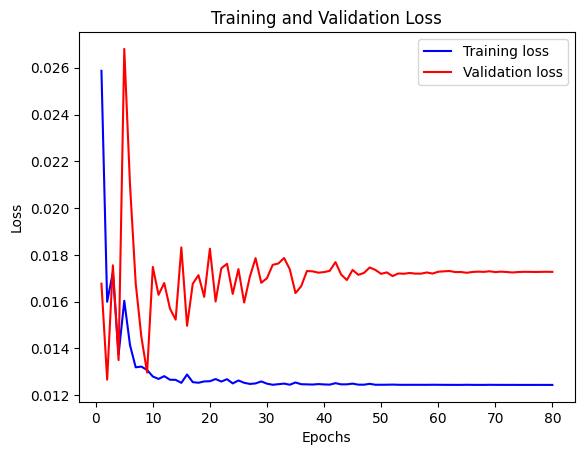

4/4 [==============================] - 0s 11ms/step
the MAPE for the 4th fold is : 1.8790200463453945%
the MAPE for this training is : 2.925894616103217%
MAPE on Test Set: 2.925894616103217%
MAE on Test Set: 0.07353654920200034
MAPE on Training Set: 2.911762214712112%
MAE on Training Set: 0.07292862552517344


In [12]:
merged_df_train = merged_df_R_D.drop(columns = ["ISO"])

MAPE_test, MAE_test, MAPE_train, MAE_train = train_and_evaluate_yearly_basis(merged_df_train, 5)

# Printing each value
print(f"MAPE on Test Set: {MAPE_test}%")
print(f"MAE on Test Set: {MAE_test}")
print(f"MAPE on Training Set: {MAPE_train}%")
print(f"MAE on Training Set: {MAE_train}")


In [13]:
def quartile(month):
    """
    Determine the quartile (quarter) of a given month.

    This function takes an integer representing a month (1 to 12) and returns the corresponding quartile based on the calendar year:
    - 1: January to March
    - 2: April to June
    - 3: July to September
    - 4: October to December

    Parameters:
        month (int): An integer representing a month (1 to 12).

    Returns:
        int: The quartile (quarter) to which the given month belongs.
    """
    if 1 <= month <= 3:
        return 1  # January to March
    elif 4 <= month <= 6:
        return 2  # April to June
    elif 7 <= month <= 9:
        return 3  # July to September
    else:
        return 4  # October to December


In [42]:
#Loading google trends data
google_trends_data1 = pd.read_csv("./data/google_trends_data_1")
google_trends_data2 = pd.read_csv("./data/google_trends_data_2")
google_trends_data3 = pd.read_csv("./data/google_trends_data_3")
google_trends_data4 = pd.read_csv("./data/google_trends_data_4")
google_trends_data5 = pd.read_csv("./data/google_trends_data_5")
google_trends_data6 = pd.read_csv("./data/google_trends_data_6")



In [15]:
# Merging the dataframes
merged_data_google_trends = pd.merge(google_trends_data1, google_trends_data2, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data3, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data4, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data5, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data6, on=["Country", "year", "month","date"], how='inner')

#Replacing each month with its corresponding quartile of the year
merged_data_google_trends["month"] = merged_data_google_trends["month"].apply(lambda x : quartile(x))
merged_data_google_trends.rename(columns={'month': 'quartile'}, inplace=True)
merged_data_google_trends = merged_data_google_trends.drop(columns = ["date"])

#Add a year to every row, so that google trends data match the actual predicted value of R&D expanditures
merged_data_google_trends["year"] = merged_data_google_trends["year"] +1

#Average over all values for months within a quartile
merged_data_google_trends = merged_data_google_trends.groupby(["year","Country","quartile"]).mean()
merged_data_google_trends = merged_data_google_trends.reset_index()

#replace country names with appropriate ISO encoding
replacements = {
    'CA': 'CAN', 'CH': 'CHE', 'CN': 'CHN', 'DE': 'DEU', 'FR': 'FRA', 
    'GB': 'GBR', 'JP': 'JPN', 'KR': 'KOR', 'US': 'USA', 'RU': 'RUS',
    'IT': 'ITA', 'AU': 'AUS', 'ES': 'ESP', 'NL': 'NLD', 'SE': 'SWE', 
    'FI': 'FIN', 'BE': 'BEL', 'TW': 'TWN', 'SG': 'SGP', 'AT': 'AUT', 
    'DK': 'DNK', 'NO': 'NOR', 'PL': 'POL', 'TR': 'TUR', 'PT': 'PRT', 
    'IE': 'IRL', 'CZ': 'CZE'
}

merged_data_google_trends['Country'] = merged_data_google_trends['Country'].replace(replacements, regex=True)
merged_data_google_trends.rename(columns={'Country': 'ISO'}, inplace=True)

merged_data_google_trends

,year,ISO,quartile,Aerospace & Defense,Chemicals Industry,Pharmaceuticals & Biotech,Computers & Electronics,Automotive Industry,Fuel Economy,Biological Sciences,...,Jobs & Education,Crime & Justice,Social Services,Business News,Health News,Politics,Social Issues & Advocacy,Real Estate,Astronomy,Ecology & Environment
0,2006,CAN,1,91.333333,94.333333,96.333333,92.000000,82.333333,19.000000,87.666667,...,85.666667,92.666667,57.333333,91.000000,15.333333,94.666667,86.666667,66.666667,91.000000,86.000000
1,2006,CAN,2,74.333333,86.333333,86.666667,76.333333,82.000000,21.666667,83.666667,...,87.000000,85.000000,50.333333,78.000000,17.333333,82.000000,83.333333,48.666667,79.666667,79.000000
2,2006,CAN,3,82.000000,81.000000,79.666667,72.666667,83.333333,58.666667,69.333333,...,81.000000,81.333333,47.000000,62.666667,12.000000,70.666667,86.000000,39.666667,76.666667,56.000000
3,2006,CAN,4,65.333333,83.666667,78.000000,80.000000,78.000000,20.000000,89.000000,...,82.333333,89.000000,50.666667,83.666667,21.000000,84.666667,68.000000,49.333333,73.333333,74.333333
4,2006,CHE,1,79.666667,92.000000,92.000000,89.000000,79.000000,48.000000,92.666667,...,90.666667,91.333333,66.333333,95.666667,26.666667,80.666667,92.000000,72.666667,95.666667,65.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,2021,KOR,4,76.666667,87.666667,82.333333,92.333333,23.000000,69.000000,83.000000,...,89.000000,85.333333,87.000000,73.333333,56.000000,88.000000,84.666667,63.666667,81.333333,83.666667
572,2021,USA,1,29.000000,69.333333,27.000000,30.333333,30.666667,22.000000,50.333333,...,64.000000,42.666667,44.000000,28.333333,8.333333,50.333333,59.666667,18.666667,27.666667,35.666667
573,2021,USA,2,39.333333,84.333333,28.333333,33.000000,28.000000,18.666667,55.666667,...,68.666667,88.333333,74.333333,30.333333,5.000000,59.666667,64.666667,20.000000,28.666667,34.000000
574,2021,USA,3,31.000000,76.333333,29.000000,33.000000,27.000000,15.333333,55.666667,...,61.000000,70.333333,49.333333,24.333333,7.333333,51.666667,67.666667,19.333333,28.000000,44.666667


In [16]:
def filter_uncorrelated_features(combined_data_quartiles, merged_df_R_D, correlation_threshold=0.12):
    """
    Filter features based on their correlation with a target variable.

    This function filters the features in the `combined_data_quartiles` DataFrame based on their correlation with the target variable 'v'
    from the `merged_df_R_D` DataFrame. Features with an absolute correlation coefficient greater than or equal to the specified
    `correlation_threshold` are retained.

    Parameters:
        combined_data_quartiles (pandas.DataFrame): The DataFrame containing features for filtering.
        merged_df_R_D (pandas.DataFrame): The DataFrame containing the target variable 'v'.
        correlation_threshold (float, optional): The minimum absolute correlation coefficient for feature retention.
            Defaults to 0.1.

    Returns:
        list of str: A list of feature names that meet the correlation threshold.
    """
    R_D_values = pd.DataFrame(merged_df_R_D[["ISO", "year", "v"]])

    # Join features (X_train) and target (y_train) to compute correlations
    # This ensures that the indices are aligned
    data = pd.merge(combined_data_quartiles, R_D_values, on=['ISO', 'year'], how='inner')

    # Compute correlation matrix
    data = data.drop(axis=1, columns=["ISO", "year"])
    correlation_matrix = data.corr()

    # Get the absolute correlation values with the target variable
    feature_correlation = correlation_matrix['v'].abs().sort_values(ascending=False)

    # Drop the target variable correlation with itself
    feature_correlation = feature_correlation.drop(labels=['v'])

    # Keep only features with correlation above or equal to the threshold
    features_kept = []
    correlations = []
    for feature, corr in feature_correlation.items():
        if correlation_threshold <= corr:
            features_kept.append(feature)
            correlations.append(corr)
    
    return features_kept,correlations


In [17]:
#Combine data of quartiles in order to use it for a yearly prediction basis
combined_data_quartiles = merged_data_google_trends.groupby(['ISO', 'year', 'quartile']).mean()
combined_data_quartiles = combined_data_quartiles.reset_index()
combined_data_quartiles = combined_data_quartiles.drop(columns=["quartile"])

#Keeping this copy for feature selection afterwards
full_combined_data_quartiles = combined_data_quartiles.copy()

#Keep only features with a minimum threshold of correlation with the output
features_kept,correlations = filter_uncorrelated_features(combined_data_quartiles,merged_df_R_D,correlation_threshold=0.12)
print(features_kept)


combined_data_quartiles = combined_data_quartiles.loc[:,features_kept+["ISO","year"]]
combined_data_quartiles

['Web Apps & Online Tools', 'Business Finance', 'Pharmaceutical Manufacturing', 'Data Management_y', 'Venture Capital', 'Pharmaceuticals & Biotech', 'Genetics', 'Automotive Industry', 'Nanobiotechnology', 'Software Utilities', 'Oil & Gas', 'Renewable Energy', 'Renewable Energy (Subcategory of Energy & Utilities)', 'Risk Management', 'Environmental Science', 'Artificial Intelligence']


,Web Apps & Online Tools,Business Finance,Pharmaceutical Manufacturing,Data Management_y,Venture Capital,Pharmaceuticals & Biotech,Genetics,Automotive Industry,Nanobiotechnology,Software Utilities,Oil & Gas,Renewable Energy,Renewable Energy (Subcategory of Energy & Utilities),Risk Management,Environmental Science,Artificial Intelligence,ISO,year
0,68.333333,94.666667,94.000000,85.000000,51.666667,96.333333,86.333333,82.333333,97.333333,95.000000,92.333333,92.000000,92.000000,93.333333,57.000000,93.666667,CAN,2006
1,67.666667,75.666667,78.000000,75.000000,46.333333,86.666667,70.000000,82.000000,83.000000,78.000000,88.333333,87.000000,87.000000,81.666667,44.000000,74.333333,CAN,2006
2,75.000000,82.000000,74.000000,66.333333,35.000000,79.666667,64.333333,83.333333,74.666667,77.333333,76.000000,76.000000,75.666667,69.000000,37.333333,65.000000,CAN,2006
3,67.666667,74.333333,81.333333,78.333333,46.000000,78.000000,85.000000,78.000000,81.000000,82.333333,80.333333,80.000000,80.000000,73.333333,54.000000,81.333333,CAN,2006
4,74.333333,83.333333,83.000000,95.000000,44.666667,83.333333,84.000000,77.333333,77.000000,76.666667,82.666667,83.333333,83.000000,79.333333,51.666667,75.333333,CAN,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,55.666667,59.000000,57.000000,51.666667,18.333333,24.333333,34.666667,41.333333,33.333333,51.666667,37.333333,36.666667,36.333333,31.000000,47.000000,48.333333,USA,2020
572,55.333333,65.333333,61.666667,53.000000,18.000000,27.000000,37.000000,30.666667,34.333333,53.666667,36.000000,36.000000,36.000000,31.000000,49.666667,46.000000,USA,2021
573,57.000000,71.000000,52.666667,54.000000,15.000000,28.333333,31.000000,28.000000,41.666667,54.666667,39.666667,39.666667,39.666667,31.000000,57.333333,48.000000,USA,2021
574,52.666667,75.000000,55.000000,53.000000,15.000000,29.000000,27.333333,27.000000,39.333333,53.333333,36.000000,36.000000,35.666667,29.333333,57.000000,45.000000,USA,2021


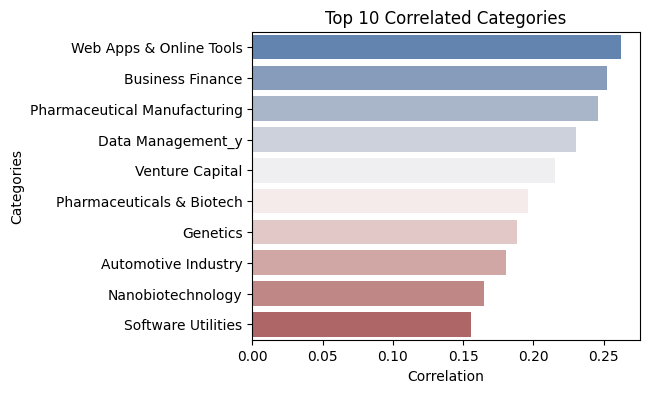

In [18]:
# Combine the lists into a list of tuples and sort by the absolute value of correlations
combined = list(zip(features_kept, correlations))
combined_sorted = sorted(combined, key=lambda x: abs(x[1]), reverse=True)

# Select the top 10 features
top_10_features = combined_sorted[:10]

# Unzip the features and their corresponding correlations
top_features, top_correlations = zip(*top_10_features)

# Create a bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=list(top_correlations), y=list(top_features), hue=list(top_features), palette="vlag", legend=False)
plt.title('Top 10 Correlated Categories')
plt.xlabel('Correlation')
plt.ylabel('Categories')
plt.savefig('correlations.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [19]:
# Merging Google Trends data and R&D expenditure values
# In this merge, 'v-2' corresponds to the R&D expenditure value from 2 years ago,
# 'v-1' corresponds to the R&D expenditure of the previous year,
# and 'v' represents the difference we aim to predict between the current year
# and the previous year's R&D expenditure value.

google_trends_data = pd.merge(first_merged, combined_data_quartiles, on=['ISO', 'year'], how='inner')
merged_data = google_trends_data.copy().groupby(["ISO","year"]).mean().reset_index()
google_trends_data = google_trends_data.drop(axis =1 ,columns=["ISO","v-2"])
google_trends_data

,year,v-1,v,Web Apps & Online Tools,Business Finance,Pharmaceutical Manufacturing,Data Management_y,Venture Capital,Pharmaceuticals & Biotech,Genetics,Automotive Industry,Nanobiotechnology,Software Utilities,Oil & Gas,Renewable Energy,Renewable Energy (Subcategory of Energy & Utilities),Risk Management,Environmental Science,Artificial Intelligence
0,2006,1.971243,-0.028245,68.333333,94.666667,94.000000,85.000000,51.666667,96.333333,86.333333,82.333333,97.333333,95.000000,92.333333,92.000000,92.000000,93.333333,57.000000,93.666667
1,2006,1.971243,-0.028245,67.666667,75.666667,78.000000,75.000000,46.333333,86.666667,70.000000,82.000000,83.000000,78.000000,88.333333,87.000000,87.000000,81.666667,44.000000,74.333333
2,2006,1.971243,-0.028245,75.000000,82.000000,74.000000,66.333333,35.000000,79.666667,64.333333,83.333333,74.666667,77.333333,76.000000,76.000000,75.666667,69.000000,37.333333,65.000000
3,2006,1.971243,-0.028245,67.666667,74.333333,81.333333,78.333333,46.000000,78.000000,85.000000,78.000000,81.000000,82.333333,80.333333,80.000000,80.000000,73.333333,54.000000,81.333333
4,2007,1.942999,-0.039421,74.333333,83.333333,83.000000,95.000000,44.666667,83.333333,84.000000,77.333333,77.000000,76.666667,82.666667,83.333333,83.000000,79.333333,51.666667,75.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2020,3.170487,0.297284,55.666667,59.000000,57.000000,51.666667,18.333333,24.333333,34.666667,41.333333,33.333333,51.666667,37.333333,36.666667,36.333333,31.000000,47.000000,48.333333
508,2021,3.467771,-0.010725,55.333333,65.333333,61.666667,53.000000,18.000000,27.000000,37.000000,30.666667,34.333333,53.666667,36.000000,36.000000,36.000000,31.000000,49.666667,46.000000
509,2021,3.467771,-0.010725,57.000000,71.000000,52.666667,54.000000,15.000000,28.333333,31.000000,28.000000,41.666667,54.666667,39.666667,39.666667,39.666667,31.000000,57.333333,48.000000
510,2021,3.467771,-0.010725,52.666667,75.000000,55.000000,53.000000,15.000000,29.000000,27.333333,27.000000,39.333333,53.333333,36.000000,36.000000,35.666667,29.333333,57.000000,45.000000


### R&D ESTIMATION ON A YEARLY BASIS (GOOGLE TRENDS DATA)


Epoch 1/80
41/41 [==============================] - 4s 30ms/step - loss: 14.7252 - val_loss: 0.0319 - lr: 0.0010
Epoch 2/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0559 - val_loss: 0.0216 - lr: 0.0010
Epoch 3/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0352 - val_loss: 0.1431 - lr: 0.0010
Epoch 4/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0385 - val_loss: 0.0164 - lr: 0.0010
Epoch 5/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0309 - val_loss: 0.0798 - lr: 0.0010
Epoch 6/80
41/41 [==============================] - 1s 21ms/step - loss: 0.1106 - val_loss: 0.0136 - lr: 0.0010
Epoch 7/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0154 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0127 - val_loss: 0.0218 - lr: 0.0010
Epoch 9/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0153 - val_loss: 0.0113 - lr

Epoch 72/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 5.5166e-06
Epoch 73/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 4.9916e-06
Epoch 74/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 4.5166e-06
Epoch 75/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 4.0868e-06
Epoch 76/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 3.6979e-06
Epoch 77/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 3.3460e-06
Epoch 78/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 3.0276e-06
Epoch 79/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 2.7394e-06
Epoch 80/80
13/13 [==============================] - 0s 8ms/step

41/41 [==============================] - 1s 26ms/step - loss: 0.0051 - val_loss: 0.0112 - lr: 1.6573e-05
Epoch 62/80
41/41 [==============================] - 1s 26ms/step - loss: 0.0051 - val_loss: 0.0112 - lr: 1.4996e-05
Epoch 63/80
41/41 [==============================] - 1s 26ms/step - loss: 0.0051 - val_loss: 0.0109 - lr: 1.3569e-05
Epoch 64/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0052 - val_loss: 0.0112 - lr: 1.2277e-05
Epoch 65/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0051 - val_loss: 0.0116 - lr: 1.1109e-05
Epoch 66/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0052 - val_loss: 0.0110 - lr: 1.0052e-05
Epoch 67/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0051 - val_loss: 0.0109 - lr: 9.0953e-06
Epoch 68/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0051 - val_loss: 0.0111 - lr: 8.2298e-06
Epoch 69/80
41/41 [==============================] - 1s 24ms/step - loss: 0.

41/41 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0128 - lr: 4.9787e-05
Epoch 51/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0053 - val_loss: 0.0119 - lr: 4.5049e-05
Epoch 52/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0142 - lr: 4.0762e-05
Epoch 53/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0055 - val_loss: 0.0112 - lr: 3.6883e-05
Epoch 54/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0054 - val_loss: 0.0132 - lr: 3.3373e-05
Epoch 55/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0114 - lr: 3.0197e-05
Epoch 56/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0136 - lr: 2.7324e-05
Epoch 57/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0053 - val_loss: 0.0127 - lr: 2.4724e-05
Epoch 58/80
41/41 [==============================] - 1s 21ms/step - loss: 0.

41/41 [==============================] - 1s 24ms/step - loss: 0.0065 - val_loss: 0.0109 - lr: 1.4957e-04
Epoch 40/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0060 - val_loss: 0.0121 - lr: 1.3534e-04
Epoch 41/80
41/41 [==============================] - 1s 25ms/step - loss: 0.0062 - val_loss: 0.0109 - lr: 1.2246e-04
Epoch 42/80
41/41 [==============================] - 1s 22ms/step - loss: 0.0060 - val_loss: 0.0112 - lr: 1.1080e-04
Epoch 43/80
41/41 [==============================] - 1s 29ms/step - loss: 0.0059 - val_loss: 0.0109 - lr: 1.0026e-04
Epoch 44/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0062 - val_loss: 0.0116 - lr: 9.0718e-05
Epoch 45/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0062 - val_loss: 0.0106 - lr: 8.2085e-05
Epoch 46/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0058 - val_loss: 0.0117 - lr: 7.4274e-05
Epoch 47/80
41/41 [==============================] - 1s 24ms/step - loss: 0.

41/41 [==============================] - 1s 24ms/step - loss: 0.0073 - val_loss: 0.0167 - lr: 4.4933e-04
Epoch 29/80
41/41 [==============================] - 1s 22ms/step - loss: 0.0070 - val_loss: 0.0098 - lr: 4.0657e-04
Epoch 30/80
41/41 [==============================] - 1s 27ms/step - loss: 0.0061 - val_loss: 0.0100 - lr: 3.6788e-04
Epoch 31/80
41/41 [==============================] - 1s 22ms/step - loss: 0.0061 - val_loss: 0.0107 - lr: 3.3287e-04
Epoch 32/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0072 - val_loss: 0.0097 - lr: 3.0119e-04
Epoch 33/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0066 - val_loss: 0.0105 - lr: 2.7253e-04
Epoch 34/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0059 - val_loss: 0.0099 - lr: 2.4660e-04
Epoch 35/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0059 - val_loss: 0.0100 - lr: 2.2313e-04
Epoch 36/80
41/41 [==============================] - 1s 24ms/step - loss: 0.

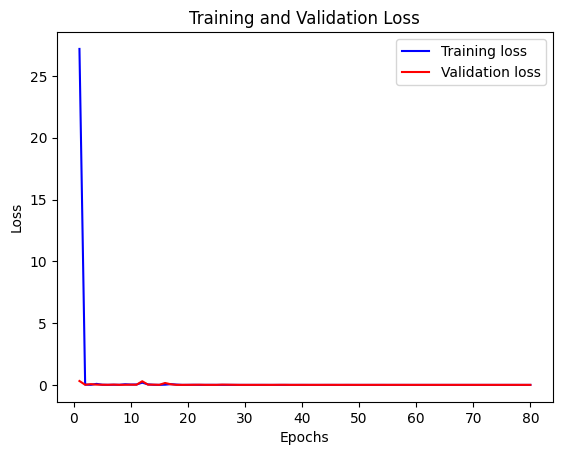

13/13 [==============================] - 0s 7ms/step
the MAPE for the 4th fold is : 2.8289599753999717%
the MAPE for this training is : 2.5329930116551393%
MAPE on Test Set: 2.5329930116551393%
MAE on Test Set: 0.0643895811520075
MAPE on Training Set: 2.139834564801866%
MAE on Training Set: 0.05502940079757566


In [20]:
MAPE_test, MAE_test, MAPE_train, MAE_train = train_and_evaluate_yearly_basis(google_trends_data,5,True)

# Printing each value
print(f"MAPE on Test Set: {MAPE_test}%")
print(f"MAE on Test Set: {MAE_test}")
print(f"MAPE on Training Set: {MAPE_train}%")
print(f"MAE on Training Set: {MAE_train}")


## Practial exemple : Predicting R&D expenditures from 2017 to 2020 for Germany and Great Britain

For this example, we consider the training sample to be the R&D expanditures from 2005  up to 2018 , the test samples will be R&D expanditures from 2018 to 2020 for both Germany and Great Britain

In [21]:
# Splitting the merged data into training and testing sets based on the year
X_train = merged_data[merged_data["year"] <= 2015]  # Training set: Data up to the year 2015
X_test = merged_data[merged_data["year"] >= 2016]  # Initial test set: Data from 2016 onwards
X_test = X_test[2020 >= X_test["year"]]  # Final test set: Data up to the year 2020

# Separating the test set data for Germany (ISO code 'DEU') and Great Britain (ISO code 'GBR')
X_test_1 = X_test[X_test["ISO"] == "DEU"]  # Test set for Germany
X_test_2 = X_test[X_test["ISO"] == "GBR"]  # Test set for Great Britain

# Dropping the 'ISO' and 'v-2' columns from the training and test sets
X_train = X_train.drop(axis=1, columns=["ISO", "v-2"])
X_test_1 = X_test_1.drop(axis=1, columns=["ISO", "v-2"])
X_test_2 = X_test_2.drop(axis=1, columns=["ISO", "v-2"])

# Extracting the target variable 'v' for training and test sets
y_test_1 = X_test_1['v']  # Target variable for Germany test set
y_test_2 = X_test_2['v']  # Target variable for Great Britain test set
y_train = X_train['v']  # Target variable for training set

# Extracting the 'v-1' column which represents previous year's R&D values
previous_R_D_values_1 = X_test_1["v-1"]  # Previous R&D values for Germany
previous_R_D_values_2 = X_test_2["v-1"]  # Previous R&D values for Great Britain

# Dropping the 'v-1', 'v', and 'year' columns from the training and test sets
X_train = X_train.drop(axis=1, columns=["v-1", "v", "year"])
X_test_1 = X_test_1.drop(axis=1, columns=["v-1", "v", "year"])
X_test_2 = X_test_2.drop(axis=1, columns=["v-1", "v", "year"])

# Determining the input shape for the neural network model
input_shape = X_train.shape[1]

# Training a Neural Network model with the optimized parameters
model, _ = NN_optimized(X_train, y_train, input_shape, 0.001, 8, epochs=80)

# Making predictions on the test set for both countries
y_pred_1 = model.predict(X_test_1)  # Predictions for Germany
y_pred_2 = model.predict(X_test_2)  # Predictions for Great Britain

# Calculating true and predicted R&D expenditure values by adding the previous year's values
R_D_true_values_1 = previous_R_D_values_1 + y_test_1  # Actual R&D values for Germany
R_D_predicted_values_1 = previous_R_D_values_1 + y_pred_1.flatten()  # Predicted R&D values for Germany
R_D_true_values_2 = previous_R_D_values_2 + y_test_2  # Actual R&D values for Great Britain
R_D_predicted_values_2 = previous_R_D_values_2 + y_pred_2.flatten()  # Predicted R&D values for Great Britain

# Calculating the average percentage difference (Mean Absolute Percentage Error, MAPE) for the test sets
avg_percentage_diff_1 = np.mean((np.abs(R_D_true_values_1 - R_D_predicted_values_1) / R_D_true_values_1) * 100)
print(f"The average MAPE for the Germany test set is : {avg_percentage_diff_1}%")

avg_percentage_diff_2 = np.mean((np.abs(R_D_true_values_2 - R_D_predicted_values_2) / R_D_true_values_2) * 100)
print(f"The average MAPE for the Great Britain test set is : {avg_percentage_diff_2}%")


Epoch 1/80
9/9 [==============================] - 3s 72ms/step - loss: 156.5036 - val_loss: 18.8676 - lr: 0.0010
Epoch 2/80
9/9 [==============================] - 0s 30ms/step - loss: 8.9975 - val_loss: 5.3359 - lr: 0.0010
Epoch 3/80
9/9 [==============================] - 0s 30ms/step - loss: 2.7904 - val_loss: 2.6912 - lr: 0.0010
Epoch 4/80
9/9 [==============================] - 0s 28ms/step - loss: 1.5228 - val_loss: 0.2777 - lr: 0.0010
Epoch 5/80
9/9 [==============================] - 0s 26ms/step - loss: 0.3572 - val_loss: 0.0419 - lr: 0.0010
Epoch 6/80
9/9 [==============================] - 0s 29ms/step - loss: 0.1011 - val_loss: 0.3032 - lr: 0.0010
Epoch 7/80
9/9 [==============================] - 0s 29ms/step - loss: 0.2031 - val_loss: 0.1512 - lr: 0.0010
Epoch 8/80
9/9 [==============================] - 0s 27ms/step - loss: 0.1481 - val_loss: 0.0628 - lr: 0.0010
Epoch 9/80
9/9 [==============================] - 0s 33ms/step - loss: 0.0458 - val_loss: 0.0709 - lr: 0.0010
Epoch 1

Epoch 73/80
9/9 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0098 - lr: 4.9916e-06
Epoch 74/80
9/9 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0099 - lr: 4.5166e-06
Epoch 75/80
9/9 [==============================] - 0s 31ms/step - loss: 0.0065 - val_loss: 0.0101 - lr: 4.0868e-06
Epoch 76/80
9/9 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0100 - lr: 3.6979e-06
Epoch 77/80
9/9 [==============================] - 0s 30ms/step - loss: 0.0065 - val_loss: 0.0099 - lr: 3.3460e-06
Epoch 78/80
9/9 [==============================] - 0s 36ms/step - loss: 0.0065 - val_loss: 0.0099 - lr: 3.0276e-06
Epoch 79/80
9/9 [==============================] - 0s 33ms/step - loss: 0.0065 - val_loss: 0.0100 - lr: 2.7394e-06
Epoch 80/80
1/1 [==============================] - 0s 69ms/step
The average MAPE for the Germany test set is : 1.815672609480656%
The average MAPE for the Great Britain test set is : 7.6243147704

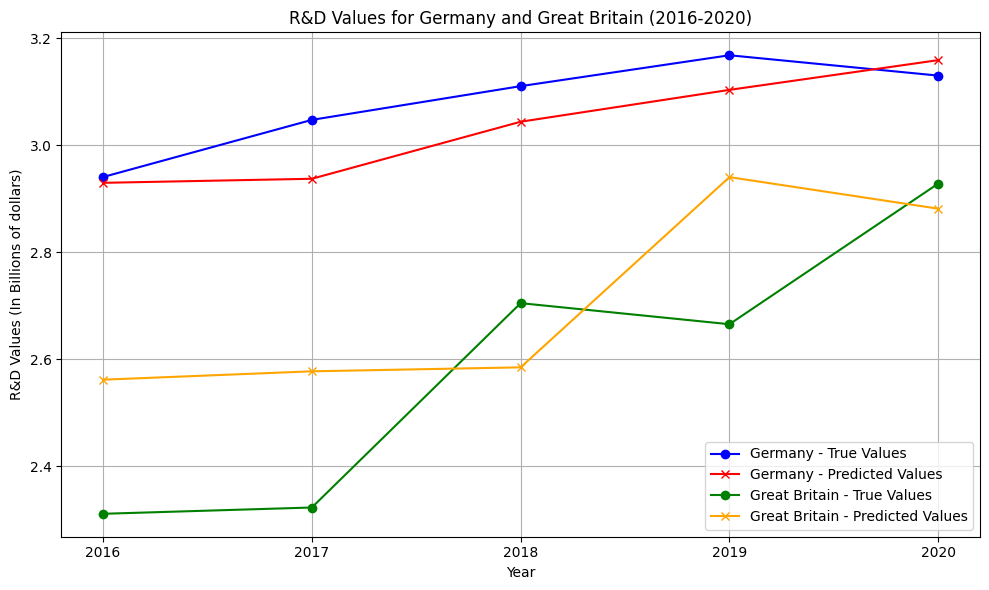

In [22]:
import matplotlib.pyplot as plt

# Years from 2016 to 2021
years = [2016, 2017, 2018, 2019, 2020]

# Assuming R_D_true_values_1, R_D_predicted_values_1, R_D_true_values_2, and R_D_predicted_values_2 
# are already defined with the R&D expenditure values for Germany and Great Britain.

# Create a combined plot
plt.figure(figsize=(10, 6))

# Plot for Germany
plt.plot(years, R_D_true_values_1, marker='o', label='Germany - True Values', color='blue')
plt.plot(years, R_D_predicted_values_1, marker='x', label='Germany - Predicted Values', color='red')

# Plot for Great Britain
plt.plot(years, R_D_true_values_2, marker='o', label='Great Britain - True Values', color='green')
plt.plot(years, R_D_predicted_values_2, marker='x', label='Great Britain - Predicted Values', color='orange')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('R&D Values (In Billions of dollars)')
plt.title('R&D Values for Germany and Great Britain (2016-2020)')
plt.legend()

# Set x-axis to display years as integers
plt.xticks(years)

# Show grid and adjust layout
plt.grid(True)
plt.tight_layout()
plt.savefig('DEUvsGBR.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()


## Choices of parameters

### 1 -  NN width

In [23]:
NN_widths = [64,128,256,512,1024,2048,4096,8192,16384,32768]

# List to store average percentage differences for each width
avg_percentages_diffs_NN_widths = []


#Evaluating for Width 64
print("Evaluating for NN_width 64")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_64)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 128
print("Evaluating for NN_width 128")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_128)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 256
print("Evaluating for NN_width 256")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_256)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 512
print("Evaluating for NN_width 512")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_512)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 1024
print("Evaluating for NN_width 1024")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_1024)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 2048
print("Evaluating for NN_width 2048")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_2048)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 4096
print("Evaluating for NN_width 4096")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_4096)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 8192
print("Evaluating for NN_width 8192")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_8192)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 16384
print("Evaluating for NN_width 16384")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_16384)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 32768
print("Evaluating for NN_width 32768")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_32768)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)


Evaluating for NN_width 64
Epoch 1/80
17/17 [==============================] - 2s 31ms/step - loss: 337.7343 - val_loss: 137.4008 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 10ms/step - loss: 75.3689 - val_loss: 35.7423 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 9ms/step - loss: 31.4384 - val_loss: 21.1836 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 10ms/step - loss: 21.0740 - val_loss: 17.3172 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 9ms/step - loss: 18.6739 - val_loss: 13.6906 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 8ms/step - loss: 15.1993 - val_loss: 11.8676 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 8ms/step - loss: 11.7755 - val_loss: 9.4842 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 7ms/step - loss: 9.6586 - val_loss: 7.3027 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 9ms/step - l

Epoch 72/80
17/17 [==============================] - 0s 9ms/step - loss: 0.9702 - val_loss: 1.0552 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 8ms/step - loss: 0.9701 - val_loss: 1.0522 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 8ms/step - loss: 0.9692 - val_loss: 1.0526 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 8ms/step - loss: 0.9692 - val_loss: 1.0525 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 8ms/step - loss: 0.9688 - val_loss: 1.0534 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 8ms/step - loss: 0.9686 - val_loss: 1.0550 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 7ms/step - loss: 0.9686 - val_loss: 1.0548 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 8ms/step - loss: 0.9684 - val_loss: 1.0538 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 7ms/step
The MAPE 

17/17 [==============================] - 0s 9ms/step - loss: 0.1349 - val_loss: 0.1473 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 9ms/step - loss: 0.1342 - val_loss: 0.1471 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 8ms/step - loss: 0.1335 - val_loss: 0.1464 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 8ms/step - loss: 0.1336 - val_loss: 0.1459 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 9ms/step - loss: 0.1334 - val_loss: 0.1483 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 9ms/step - loss: 0.1334 - val_loss: 0.1465 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 8ms/step - loss: 0.1331 - val_loss: 0.1467 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 8ms/step - loss: 0.1332 - val_loss: 0.1468 - lr: 7.4466e-06
Epoch 70/80
17/17 [==============================] - 0s 8ms/step - loss: 0.1334 - va

17/17 [==============================] - 0s 8ms/step - loss: 0.0437 - val_loss: 0.1462 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0411 - val_loss: 0.1468 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0415 - val_loss: 0.1450 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0413 - val_loss: 0.1481 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.1460 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.1466 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0410 - val_loss: 0.1469 - lr: 2.2371e-05
Epoch 59/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0412 - val_loss: 0.1475 - lr: 2.0242e-05
Epoch 60/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0408 - va

17/17 [==============================] - 0s 8ms/step - loss: 0.7678 - val_loss: 0.9950 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 0s 7ms/step - loss: 0.7649 - val_loss: 0.9866 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 8ms/step - loss: 0.7545 - val_loss: 0.9731 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 8ms/step - loss: 0.7528 - val_loss: 0.9681 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 7ms/step - loss: 0.7457 - val_loss: 0.9651 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 0s 8ms/step - loss: 0.7429 - val_loss: 0.9609 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 9ms/step - loss: 0.7386 - val_loss: 0.9537 - lr: 6.0810e-05
Epoch 49/80
17/17 [==============================] - 0s 8ms/step - loss: 0.7324 - val_loss: 0.9536 - lr: 5.5023e-05
Epoch 50/80
17/17 [==============================] - 0s 9ms/step - loss: 0.7253 - va

17/17 [==============================] - 0s 8ms/step - loss: 0.0140 - val_loss: 0.0493 - lr: 3.0119e-04
Epoch 33/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0162 - val_loss: 0.0460 - lr: 2.7253e-04
Epoch 34/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0470 - lr: 2.4660e-04
Epoch 35/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0492 - lr: 2.2313e-04
Epoch 36/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0144 - val_loss: 0.0502 - lr: 2.0190e-04
Epoch 37/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0141 - val_loss: 0.0478 - lr: 1.8268e-04
Epoch 38/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0132 - val_loss: 0.0448 - lr: 1.6530e-04
Epoch 39/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0127 - val_loss: 0.0440 - lr: 1.4957e-04
Epoch 40/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0141 - v

17/17 [==============================] - 0s 9ms/step - loss: 0.0258 - val_loss: 0.0434 - lr: 8.1873e-04
Epoch 23/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0197 - val_loss: 0.0299 - lr: 7.4082e-04
Epoch 24/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0168 - val_loss: 0.0317 - lr: 6.7032e-04
Epoch 25/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0182 - val_loss: 0.0242 - lr: 6.0653e-04
Epoch 26/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0142 - val_loss: 0.0252 - lr: 5.4881e-04
Epoch 27/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0148 - val_loss: 0.0268 - lr: 4.9659e-04
Epoch 28/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0148 - val_loss: 0.0275 - lr: 4.4933e-04
Epoch 29/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0139 - val_loss: 0.0267 - lr: 4.0657e-04
Epoch 30/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0146 - va

Epoch 12/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0198 - val_loss: 0.0367 - lr: 0.0010
Epoch 13/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0221 - lr: 0.0010
Epoch 14/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0199 - val_loss: 0.0217 - lr: 0.0010
Epoch 15/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0150 - val_loss: 0.0209 - lr: 0.0010
Epoch 16/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0148 - val_loss: 0.0178 - lr: 0.0010
Epoch 17/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0135 - val_loss: 0.0209 - lr: 0.0010
Epoch 18/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0141 - val_loss: 0.0233 - lr: 0.0010
Epoch 19/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0216 - val_loss: 0.0600 - lr: 0.0010
Epoch 20/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0281 - val_loss: 0.0174 - l

17/17 [==============================] - 2s 27ms/step - loss: 376.1550 - val_loss: 79.3518 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 10ms/step - loss: 36.2322 - val_loss: 4.1346 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 11ms/step - loss: 6.8274 - val_loss: 4.5217 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 11ms/step - loss: 1.4112 - val_loss: 0.3349 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 10ms/step - loss: 0.3851 - val_loss: 0.0992 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0996 - val_loss: 0.0721 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0472 - val_loss: 0.0413 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0363 - val_loss: 0.0311 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0246 - val_loss: 0.0346 - lr: 0.0010


Epoch 72/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0109 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0109 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0109 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0109 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0109 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0109 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0109 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0109 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 5ms/step
T

17/17 [==============================] - 0s 13ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0069 - val_loss: 0.0109 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0108 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 12ms/step - loss: 0.

Epoch 51/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0093 - lr: 4.5049e-05
Epoch 52/80
17/17 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0093 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0064 - val_loss: 0.0093 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0092 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0064 - val_loss: 0.0093 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0093 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 15ms/step - loss: 0.0063 - val_loss: 0.0093 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 15ms/step - loss: 0.0063 - val_loss: 0.0092 - lr: 2.2371e-05
Epoch 59/80
17/17 [==============================] - 0s 13ms/ste

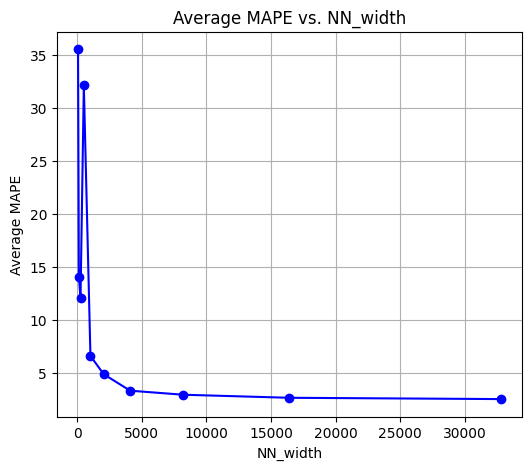

In [24]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(NN_widths, avg_percentages_diffs_NN_widths, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. NN_width')
plt.xlabel('NN_width')
plt.ylabel('Average MAPE')
plt.grid(True)
# Save the plot as a PDF
plt.savefig('width.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

### 2- NN depth

In [25]:
NN_depths = [1,3,5,7,8,9,10,11]

# List to store average percentage differences for each depth
avg_percentages_diffs_NN_depths = []


#Evaluating for Depth 1
print("Evaluating for NN_depth 1")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_1)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 3
print("Evaluating for NN_depth 3")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_3)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 5
print("Evaluating for NN_depth 5")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_5)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 7
print("Evaluating for NN_depth 7")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_7)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 8
print("Evaluating for NN_depth 8")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_8)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 9
print("Evaluating for NN_depth 9")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_9)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 10
print("Evaluating for NN_depth 10")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_10)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 11
print("Evaluating for NN_depth 11")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_11)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)



Evaluating for NN_depth 1
Epoch 1/80
17/17 [==============================] - 2s 31ms/step - loss: 712.9640 - val_loss: 227.0600 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 11ms/step - loss: 63.6522 - val_loss: 38.0480 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 13ms/step - loss: 12.6842 - val_loss: 9.5578 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 14ms/step - loss: 3.2023 - val_loss: 1.7725 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 14ms/step - loss: 0.6915 - val_loss: 0.1953 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 13ms/step - loss: 0.2166 - val_loss: 0.1640 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0893 - val_loss: 0.0640 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0487 - val_loss: 0.0406 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 14ms/step - loss

17/17 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 6.0967e-06
Epoch 72/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 13ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 11ms/step - loss: 0.

Epoch 61/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0055 - val_loss: 0.0083 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0054 - val_loss: 0.0082 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0054 - val_loss: 0.0082 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0083 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 0.0082 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0054 - val_loss: 0.0083 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 26ms/ste

Epoch 51/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0057 - val_loss: 0.0077 - lr: 4.5049e-05
Epoch 52/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0054 - val_loss: 0.0076 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0054 - val_loss: 0.0075 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0054 - val_loss: 0.0076 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0055 - val_loss: 0.0078 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 0.0076 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0054 - val_loss: 0.0075 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 2.2371e-05
Epoch 59/80
17/17 [==============================] - 0s 26ms/ste

Epoch 41/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0066 - val_loss: 0.0107 - lr: 1.2246e-04
Epoch 42/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0062 - val_loss: 0.0078 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0065 - val_loss: 0.0097 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0066 - val_loss: 0.0086 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0081 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0.0077 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0057 - val_loss: 0.0077 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0058 - val_loss: 0.0079 - lr: 6.0810e-05
Epoch 49/80
17/17 [==============================] - 0s 29ms/ste

Epoch 31/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0093 - val_loss: 0.0082 - lr: 3.3287e-04
Epoch 32/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0102 - lr: 3.0119e-04
Epoch 33/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0062 - val_loss: 0.0077 - lr: 2.7253e-04
Epoch 34/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0060 - val_loss: 0.0079 - lr: 2.4660e-04
Epoch 35/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0058 - val_loss: 0.0075 - lr: 2.2313e-04
Epoch 36/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0078 - lr: 2.0190e-04
Epoch 37/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0055 - val_loss: 0.0075 - lr: 1.8268e-04
Epoch 38/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0061 - val_loss: 0.0073 - lr: 1.6530e-04
Epoch 39/80
17/17 [==============================] - 0s 26ms/ste

Epoch 21/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 9.0484e-04
Epoch 22/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 8.1873e-04
Epoch 23/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 7.4082e-04
Epoch 24/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 6.7032e-04
Epoch 25/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 6.0653e-04
Epoch 26/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 5.4881e-04
Epoch 27/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 4.9659e-04
Epoch 28/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 4.4933e-04
Epoch 29/80
17/17 [==============================] - 0s 26ms/ste

17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 11/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 12/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 13/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 14/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 15/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 16/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 0.0010
Epoch 17/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 18/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.

4/4 [==============================] - 0s 5ms/step
The MAPE for the test set is: 2.957868518668597%
Evaluating for NN_depth 11
Epoch 1/80
17/17 [==============================] - 5s 55ms/step - loss: 0.0253 - val_loss: 0.0155 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0141 - val_loss: 0.0148 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0134 - val_loss: 0.0142 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0368 - val_loss: 0.0137 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0124 - val_loss: 0.0135 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0122 - val_loss: 0.0134 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0121 - val_loss: 0.0134 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0121 - val_los

Epoch 70/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 6.7379e-06
Epoch 71/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 6.0967e-06
Epoch 72/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 27ms/ste

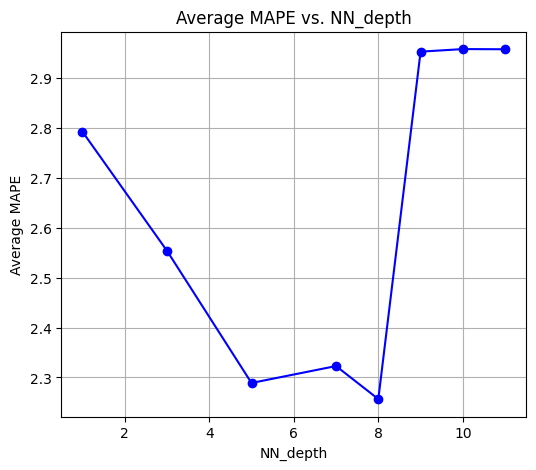

In [26]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(NN_depths, avg_percentages_diffs_NN_depths, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. NN_depth')
plt.xlabel('NN_depth')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('depth.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()


### 3 - Correlation threshold

In [27]:
# List of correlation thresholds to test
correlation_thresholds = [0.1, 0.12, 0.14,0.16,0.2]

# List to store average percentage differences for each threshold
avg_percentages_diffs = []

# Loop through each correlation threshold
for correlation_threshold in correlation_thresholds:
    print(f"Testing performance for threshold : {correlation_threshold}")
    
    # Keep only features with a minimum threshold of correlation with the output
    features_kept_test,_ = filter_uncorrelated_features(full_combined_data_quartiles, merged_df_R_D, correlation_threshold=correlation_threshold)

    # Create a DataFrame with selected features and additional columns "ISO" and "year"
    combined_data_quartiles_test = full_combined_data_quartiles.loc[:, features_kept_test + ["ISO", "year"]]

    # Merge the selected features with Google Trends data based on "ISO" and "year"
    google_trends_data_test = pd.merge(first_merged, combined_data_quartiles_test, on=['ISO', 'year'], how='inner')

    # Drop columns "ISO" and "v-2" from the merged DataFrame
    google_trends_data_test = google_trends_data_test.drop(axis=1, columns=["ISO", "v-2"])

    # Train and evaluate the model with the selected data and calculate the average percentage difference
    avg_percentage_diff = train_and_evaluate_yearly_basis_select_parameters(google_trends_data_test, True)

    # Append the average percentage difference to the list
    avg_percentages_diffs.append(avg_percentage_diff)


    

Testing performance for threshold : 0.1
Epoch 1/80
17/17 [==============================] - 3s 45ms/step - loss: 34.1160 - val_loss: 0.0640 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 26ms/step - loss: 0.2611 - val_loss: 0.2504 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 26ms/step - loss: 0.1228 - val_loss: 0.0377 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0256 - val_loss: 0.0111 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0110 - val_loss: 0.0110 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0142 - val_loss: 0.0212 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0233 - val_loss: 0.0114 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0144 - val_loss: 0.0135 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 25ms/ste

17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 6.0967e-06
Epoch 72/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 25ms/step - loss: 0.

Epoch 61/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0058 - val_loss: 0.0079 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0059 - val_loss: 0.0078 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0058 - val_loss: 0.0079 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0078 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0079 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 26ms/ste

17/17 [==============================] - 0s 26ms/step - loss: 0.0062 - val_loss: 0.0085 - lr: 4.9787e-05
Epoch 51/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0064 - val_loss: 0.0080 - lr: 4.5049e-05
Epoch 52/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0060 - val_loss: 0.0087 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0064 - val_loss: 0.0081 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0080 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0080 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 26ms/step - loss: 0.

Epoch 40/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0086 - val_loss: 0.0127 - lr: 1.3534e-04
Epoch 41/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.2246e-04
Epoch 42/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0071 - val_loss: 0.0093 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0081 - val_loss: 0.0085 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0070 - val_loss: 0.0084 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0069 - val_loss: 0.0084 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0068 - val_loss: 0.0084 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0067 - val_loss: 0.0085 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 25ms/ste

17/17 [==============================] - 0s 27ms/step - loss: 0.0087 - val_loss: 0.0094 - lr: 4.0657e-04
Epoch 30/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0107 - val_loss: 0.0090 - lr: 3.6788e-04
Epoch 31/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0129 - lr: 3.3287e-04
Epoch 32/80
17/17 [==============================] - 1s 32ms/step - loss: 0.0093 - val_loss: 0.0111 - lr: 3.0119e-04
Epoch 33/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0092 - val_loss: 0.0096 - lr: 2.7253e-04
Epoch 34/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0078 - val_loss: 0.0091 - lr: 2.4660e-04
Epoch 35/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 2.2313e-04
Epoch 36/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0076 - val_loss: 0.0084 - lr: 2.0190e-04
Epoch 37/80
17/17 [==============================] - 1s 32ms/step - loss: 0.

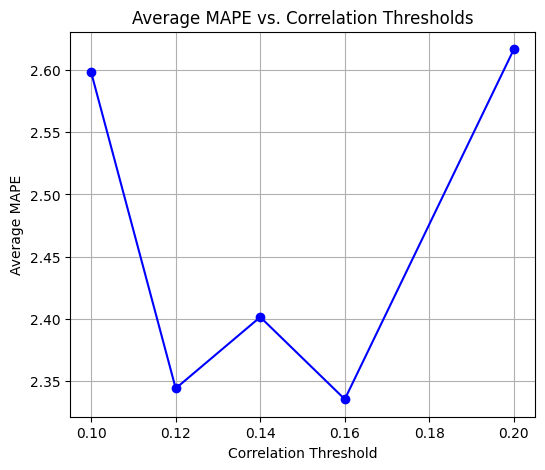

In [28]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(correlation_thresholds, avg_percentages_diffs, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Correlation Thresholds')
plt.xlabel('Correlation Threshold')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('correlations_plot.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()



### 4 - Initial learning rate of NN

In [29]:
# List of initial_rates for NN optimization to test
initial_rates = [0.00001,0.001,0.01,0.1]

# List to store average percentage differences for each initial_rate
avg_percentages_diffs_initial_rates = []

# Loop through each initial_rate
for initial_rate in initial_rates:
    print(f"Testing performance for initial_rate : {initial_rate}")
    avg_percentages_diffs_initial_rate = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,initial_rate=initial_rate)

    # Append the average percentage difference to the list
    avg_percentages_diffs_initial_rates.append(avg_percentages_diffs_initial_rate)

Testing performance for initial_rate : 1e-05
Epoch 1/80
17/17 [==============================] - 3s 50ms/step - loss: 10.3441 - val_loss: 2.0512 - lr: 1.0000e-05
Epoch 2/80
17/17 [==============================] - 0s 27ms/step - loss: 1.1586 - val_loss: 0.1801 - lr: 1.0000e-05
Epoch 3/80
17/17 [==============================] - 0s 26ms/step - loss: 0.2862 - val_loss: 0.0798 - lr: 1.0000e-05
Epoch 4/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0854 - val_loss: 0.0501 - lr: 1.0000e-05
Epoch 5/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0385 - val_loss: 0.0406 - lr: 1.0000e-05
Epoch 6/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0272 - val_loss: 0.0343 - lr: 1.0000e-05
Epoch 7/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0222 - val_loss: 0.0311 - lr: 1.0000e-05
Epoch 8/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0201 - val_loss: 0.0278 - lr: 1.0000e-05
Epoch 9/80
17/17 [========

Epoch 71/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0043 - val_loss: 0.0129 - lr: 6.0967e-08
Epoch 72/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0043 - val_loss: 0.0129 - lr: 5.5166e-08
Epoch 73/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0043 - val_loss: 0.0129 - lr: 4.9916e-08
Epoch 74/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0043 - val_loss: 0.0129 - lr: 4.5166e-08
Epoch 75/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0129 - lr: 4.0868e-08
Epoch 76/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0043 - val_loss: 0.0128 - lr: 3.6979e-08
Epoch 77/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0043 - val_loss: 0.0128 - lr: 3.3460e-08
Epoch 78/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0128 - lr: 3.0276e-08
Epoch 79/80
17/17 [==============================] - 0s 25ms/ste

17/17 [==============================] - 0s 29ms/step - loss: 0.0053 - val_loss: 0.0075 - lr: 1.8316e-05
Epoch 61/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0052 - val_loss: 0.0075 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0076 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0075 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0075 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0076 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0075 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 26ms/step - loss: 0.

17/17 [==============================] - 0s 29ms/step - loss: 0.0085 - val_loss: 0.0099 - lr: 4.9787e-04
Epoch 51/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0084 - val_loss: 0.0099 - lr: 4.5049e-04
Epoch 52/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0085 - val_loss: 0.0099 - lr: 4.0762e-04
Epoch 53/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0084 - val_loss: 0.0099 - lr: 3.6883e-04
Epoch 54/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0084 - val_loss: 0.0099 - lr: 3.3373e-04
Epoch 55/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0084 - val_loss: 0.0099 - lr: 3.0197e-04
Epoch 56/80
17/17 [==============================] - 1s 29ms/step - loss: 0.0084 - val_loss: 0.0098 - lr: 2.7324e-04
Epoch 57/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0084 - val_loss: 0.0098 - lr: 2.4724e-04
Epoch 58/80
17/17 [==============================] - 0s 26ms/step - loss: 0.

Epoch 40/80
17/17 [==============================] - 0s 25ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0135
Epoch 41/80
17/17 [==============================] - 0s 25ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0122
Epoch 42/80
17/17 [==============================] - 0s 24ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0111
Epoch 43/80
17/17 [==============================] - 0s 25ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0100
Epoch 44/80
17/17 [==============================] - 0s 25ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0091
Epoch 45/80
17/17 [==============================] - 0s 26ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0082
Epoch 46/80
17/17 [==============================] - 0s 25ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0074
Epoch 47/80
17/17 [==============================] - 0s 24ms/step - loss: 0.2421 - val_loss: 0.2409 - lr: 0.0067
Epoch 48/80
17/17 [==============================] - 0s 26ms/step - loss: 0.2421 - val_loss: 0.2

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


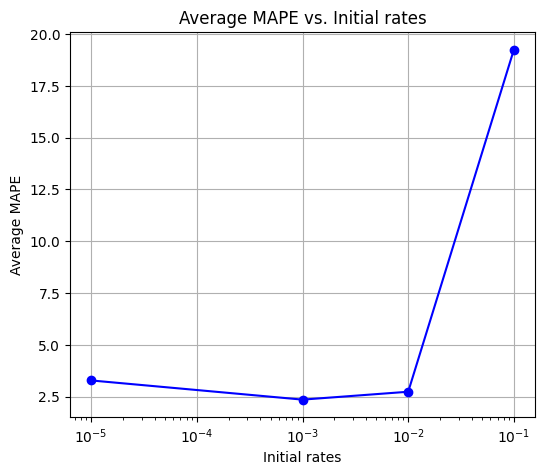

In [30]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(initial_rates, avg_percentages_diffs_initial_rates, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Initial rates')
plt.xlabel('Initial rates')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.savefig('learning_rates.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()


### 5 - Batch size of NN

In [31]:
# List of batch sizes to test
batch_sizes = [7,8,10,15,25,35,45]

# List to store average percentage differences for each batch size
avg_percentages_diffs_batch_sizes = []

for batch_size in batch_sizes:
    print(f"Testing performance for batch_size : {batch_size}")
    avg_percentages_diffs_batch_size = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,batch_size=batch_size)

    # Append the average percentage difference to the list
    avg_percentages_diffs_batch_sizes.append(avg_percentages_diffs_batch_size)

Testing performance for batch_size : 7
Epoch 1/80
47/47 [==============================] - 4s 30ms/step - loss: 17.7017 - val_loss: 0.0780 - lr: 0.0010
Epoch 2/80
47/47 [==============================] - 1s 23ms/step - loss: 0.0366 - val_loss: 0.0105 - lr: 0.0010
Epoch 3/80
47/47 [==============================] - 1s 25ms/step - loss: 0.0170 - val_loss: 0.0208 - lr: 0.0010
Epoch 4/80
47/47 [==============================] - 1s 21ms/step - loss: 0.0127 - val_loss: 0.0139 - lr: 0.0010
Epoch 5/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0109 - val_loss: 0.0093 - lr: 0.0010
Epoch 6/80
47/47 [==============================] - 1s 21ms/step - loss: 0.0127 - val_loss: 0.0104 - lr: 0.0010
Epoch 7/80
47/47 [==============================] - 1s 25ms/step - loss: 0.0137 - val_loss: 0.0168 - lr: 0.0010
Epoch 8/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0220 - val_loss: 0.0245 - lr: 0.0010
Epoch 9/80
47/47 [==============================] - 1s 21ms/step

47/47 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0073 - lr: 6.0967e-06
Epoch 72/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0041 - val_loss: 0.0073 - lr: 5.5166e-06
Epoch 73/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0075 - lr: 4.9916e-06
Epoch 74/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0041 - val_loss: 0.0073 - lr: 4.5166e-06
Epoch 75/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0041 - val_loss: 0.0073 - lr: 4.0868e-06
Epoch 76/80
47/47 [==============================] - 1s 21ms/step - loss: 0.0040 - val_loss: 0.0073 - lr: 3.6979e-06
Epoch 77/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0041 - val_loss: 0.0073 - lr: 3.3460e-06
Epoch 78/80
47/47 [==============================] - 1s 23ms/step - loss: 0.0041 - val_loss: 0.0073 - lr: 3.0276e-06
Epoch 79/80
47/47 [==============================] - 1s 26ms/step - loss: 0.

Epoch 61/80
41/41 [==============================] - 1s 16ms/step - loss: 0.0051 - val_loss: 0.0078 - lr: 1.6573e-05
Epoch 62/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0053 - val_loss: 0.0077 - lr: 1.4996e-05
Epoch 63/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0077 - lr: 1.3569e-05
Epoch 64/80
41/41 [==============================] - 1s 16ms/step - loss: 0.0052 - val_loss: 0.0077 - lr: 1.2277e-05
Epoch 65/80
41/41 [==============================] - 1s 16ms/step - loss: 0.0051 - val_loss: 0.0077 - lr: 1.1109e-05
Epoch 66/80
41/41 [==============================] - 1s 16ms/step - loss: 0.0052 - val_loss: 0.0078 - lr: 1.0052e-05
Epoch 67/80
41/41 [==============================] - 1s 16ms/step - loss: 0.0052 - val_loss: 0.0077 - lr: 9.0953e-06
Epoch 68/80
41/41 [==============================] - 1s 16ms/step - loss: 0.0052 - val_loss: 0.0077 - lr: 8.2298e-06
Epoch 69/80
41/41 [==============================] - 1s 16ms/ste

33/33 [==============================] - 1s 18ms/step - loss: 0.0056 - val_loss: 0.0080 - lr: 4.9787e-05
Epoch 51/80
33/33 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 0.0077 - lr: 4.5049e-05
Epoch 52/80
33/33 [==============================] - 1s 18ms/step - loss: 0.0059 - val_loss: 0.0077 - lr: 4.0762e-05
Epoch 53/80
33/33 [==============================] - 1s 17ms/step - loss: 0.0054 - val_loss: 0.0077 - lr: 3.6883e-05
Epoch 54/80
33/33 [==============================] - 1s 19ms/step - loss: 0.0053 - val_loss: 0.0078 - lr: 3.3373e-05
Epoch 55/80
33/33 [==============================] - 1s 17ms/step - loss: 0.0054 - val_loss: 0.0076 - lr: 3.0197e-05
Epoch 56/80
33/33 [==============================] - 1s 17ms/step - loss: 0.0053 - val_loss: 0.0079 - lr: 2.7324e-05
Epoch 57/80
33/33 [==============================] - 1s 17ms/step - loss: 0.0053 - val_loss: 0.0080 - lr: 2.4724e-05
Epoch 58/80
33/33 [==============================] - 1s 16ms/step - loss: 0.

Epoch 40/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0065 - val_loss: 0.0081 - lr: 1.3534e-04
Epoch 41/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0056 - val_loss: 0.0104 - lr: 1.2246e-04
Epoch 42/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0084 - lr: 1.1080e-04
Epoch 43/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0062 - val_loss: 0.0093 - lr: 1.0026e-04
Epoch 44/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.0080 - lr: 9.0718e-05
Epoch 45/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0086 - lr: 8.2085e-05
Epoch 46/80
22/22 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0083 - lr: 7.4274e-05
Epoch 47/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0055 - val_loss: 0.0081 - lr: 6.7206e-05
Epoch 48/80
22/22 [==============================] - 0s 18ms/ste

14/14 [==============================] - 0s 19ms/step - loss: 0.0184 - val_loss: 0.0311 - lr: 4.0657e-04
Epoch 30/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0191 - val_loss: 0.0403 - lr: 3.6788e-04
Epoch 31/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0212 - val_loss: 0.0178 - lr: 3.3287e-04
Epoch 32/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0133 - val_loss: 0.0086 - lr: 3.0119e-04
Epoch 33/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0070 - val_loss: 0.0130 - lr: 2.7253e-04
Epoch 34/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0117 - val_loss: 0.0147 - lr: 2.4660e-04
Epoch 35/80
14/14 [==============================] - 0s 22ms/step - loss: 0.0090 - val_loss: 0.0109 - lr: 2.2313e-04
Epoch 36/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0077 - val_loss: 0.0168 - lr: 2.0190e-04
Epoch 37/80
14/14 [==============================] - 0s 19ms/step - loss: 0.

10/10 [==============================] - 0s 25ms/step - loss: 0.0364 - val_loss: 0.0290 - lr: 0.0010
Epoch 19/80
10/10 [==============================] - 0s 22ms/step - loss: 0.0130 - val_loss: 0.0097 - lr: 0.0010
Epoch 20/80
10/10 [==============================] - 0s 25ms/step - loss: 0.0126 - val_loss: 0.0163 - lr: 0.0010
Epoch 21/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0259 - val_loss: 0.0086 - lr: 9.0484e-04
Epoch 22/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0137 - val_loss: 0.0086 - lr: 8.1873e-04
Epoch 23/80
10/10 [==============================] - 0s 28ms/step - loss: 0.0075 - val_loss: 0.0111 - lr: 7.4082e-04
Epoch 24/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0077 - val_loss: 0.0100 - lr: 6.7032e-04
Epoch 25/80
10/10 [==============================] - 0s 25ms/step - loss: 0.0082 - val_loss: 0.0125 - lr: 6.0653e-04
Epoch 26/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0077 - val_l

8/8 [==============================] - 0s 29ms/step - loss: 0.0388 - val_loss: 0.0599 - lr: 0.0010
Epoch 8/80
8/8 [==============================] - 0s 31ms/step - loss: 0.0319 - val_loss: 0.0254 - lr: 0.0010
Epoch 9/80
8/8 [==============================] - 0s 27ms/step - loss: 0.0179 - val_loss: 0.0147 - lr: 0.0010
Epoch 10/80
8/8 [==============================] - 0s 27ms/step - loss: 0.0130 - val_loss: 0.0136 - lr: 0.0010
Epoch 11/80
8/8 [==============================] - 0s 27ms/step - loss: 0.0117 - val_loss: 0.0126 - lr: 0.0010
Epoch 12/80
8/8 [==============================] - 0s 25ms/step - loss: 0.0126 - val_loss: 0.0139 - lr: 0.0010
Epoch 13/80
8/8 [==============================] - 0s 29ms/step - loss: 0.0113 - val_loss: 0.0197 - lr: 0.0010
Epoch 14/80
8/8 [==============================] - 0s 33ms/step - loss: 0.0158 - val_loss: 0.0129 - lr: 0.0010
Epoch 15/80
8/8 [==============================] - 0s 27ms/step - loss: 0.0145 - val_loss: 0.0313 - lr: 0.0010
Epoch 16/80
8/8

Epoch 79/80
8/8 [==============================] - 0s 25ms/step - loss: 0.0066 - val_loss: 0.0087 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 5ms/step
The MAPE for the test set is: 2.6714278256271657%


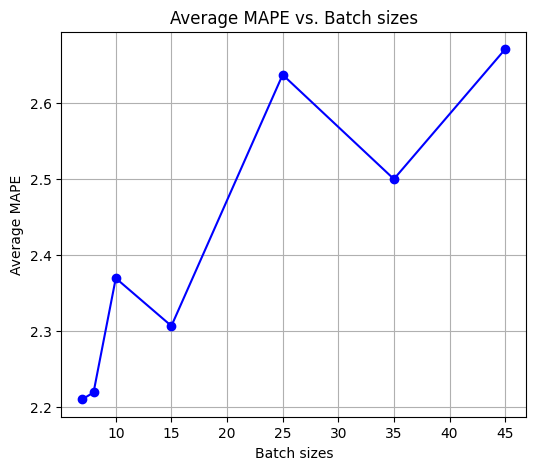

In [32]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(batch_sizes, avg_percentages_diffs_batch_sizes, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Batch sizes')
plt.xlabel('Batch sizes')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('batch_sizes.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()

### 6 - Number of epochs


In [33]:
# List of number of epochs to test
epochs = [5,10,20,40,60,80,100,120,140]

# List to store average percentage differences for each number of epochs
avg_percentages_diffs_epochs = []

for epoch in epochs:
    print(f"Testing performance for epochs : {epoch}")
    avg_percentages_diffs_epoch = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,epochs=epoch)

    # Append the average percentage difference to the list
    avg_percentages_diffs_epochs.append(avg_percentages_diffs_epoch)

Testing performance for epochs : 5
Epoch 1/5
17/17 [==============================] - 2s 30ms/step - loss: 49.4877 - val_loss: 0.0724 - lr: 0.0010
Epoch 2/5
17/17 [==============================] - 0s 18ms/step - loss: 0.2847 - val_loss: 0.0200 - lr: 0.0010
Epoch 3/5
17/17 [==============================] - 0s 20ms/step - loss: 0.2322 - val_loss: 0.0127 - lr: 0.0010
Epoch 4/5
17/17 [==============================] - 0s 18ms/step - loss: 0.0698 - val_loss: 0.0178 - lr: 0.0010
Epoch 5/5
4/4 [==============================] - 0s 4ms/step
The MAPE for the test set is: 16.43395261151175%
Testing performance for epochs : 10
Epoch 1/10
17/17 [==============================] - 2s 31ms/step - loss: 60.5287 - val_loss: 0.4816 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - 0s 17ms/step - loss: 0.2363 - val_loss: 0.0516 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - 0s 21ms/step - loss: 0.1469 - val_loss: 0.4502 - lr: 0.0010
Epoch 4/10
17/17 [===================

17/17 [==============================] - 0s 29ms/step - loss: 0.0066 - val_loss: 0.0081 - lr: 2.4660e-04
Epoch 35/40
17/17 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0081 - lr: 2.2313e-04
Epoch 36/40
17/17 [==============================] - 1s 29ms/step - loss: 0.0064 - val_loss: 0.0082 - lr: 2.0190e-04
Epoch 37/40
17/17 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0080 - lr: 1.8268e-04
Epoch 38/40
17/17 [==============================] - 0s 29ms/step - loss: 0.0070 - val_loss: 0.0107 - lr: 1.6530e-04
Epoch 39/40
17/17 [==============================] - 0s 28ms/step - loss: 0.0087 - val_loss: 0.0098 - lr: 1.4957e-04
Epoch 40/40
4/4 [==============================] - 0s 9ms/step
The MAPE for the test set is: 2.772688916409584%
Testing performance for epochs : 60
Epoch 1/60
17/17 [==============================] - 3s 50ms/step - loss: 58.3800 - val_loss: 0.1570 - lr: 0.0010
Epoch 2/60
17/17 [==============================]

17/17 [==============================] - 0s 28ms/step - loss: 0.3249 - val_loss: 0.0384 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 27ms/step - loss: 0.1101 - val_loss: 0.0673 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 28ms/step - loss: 0.2864 - val_loss: 0.0655 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0366 - val_loss: 0.0816 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 28ms/step - loss: 0.1038 - val_loss: 0.0383 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0368 - val_loss: 0.0117 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0500 - val_loss: 0.1515 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0485 - val_loss: 0.0101 - lr: 0.0010
Epoch 10/80
17/17 [==============================] - 0s 26ms/step - loss: 0.3807 - val_loss: 0.4883 - lr: 0.0010
Ep

Epoch 73/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 1s 32ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 1s 38ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 1s 38ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 1s 37ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 1s 35ms/step - loss: 0.0053 - val_loss: 0.0076 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 7ms/step
The MAPE for the test set is: 2.4438738273496483%
Testing performance for epochs : 100
Epoch 1/100
17/17 [============

17/17 [==============================] - 1s 30ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 1.4996e-05
Epoch 63/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 1.3569e-05
Epoch 64/100
17/17 [==============================] - 1s 30ms/step - loss: 0.0060 - val_loss: 0.0081 - lr: 1.2277e-05
Epoch 65/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 1.1109e-05
Epoch 66/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 1.0052e-05
Epoch 67/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 9.0953e-06
Epoch 68/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 8.2298e-06
Epoch 69/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 7.4466e-06
Epoch 70/100
17/17 [==============================] - 0s 26ms/step - 

17/17 [==============================] - 0s 27ms/step - loss: 0.0083 - val_loss: 0.0115 - lr: 3.3287e-04
Epoch 32/120
17/17 [==============================] - 1s 31ms/step - loss: 0.0077 - val_loss: 0.0153 - lr: 3.0119e-04
Epoch 33/120
17/17 [==============================] - 0s 27ms/step - loss: 0.0083 - val_loss: 0.0097 - lr: 2.7253e-04
Epoch 34/120
17/17 [==============================] - 0s 28ms/step - loss: 0.0067 - val_loss: 0.0090 - lr: 2.4660e-04
Epoch 35/120
17/17 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0088 - lr: 2.2313e-04
Epoch 36/120
17/17 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0090 - lr: 2.0190e-04
Epoch 37/120
17/17 [==============================] - 0s 27ms/step - loss: 0.0060 - val_loss: 0.0085 - lr: 1.8268e-04
Epoch 38/120
17/17 [==============================] - 0s 30ms/step - loss: 0.0074 - val_loss: 0.0087 - lr: 1.6530e-04
Epoch 39/120
17/17 [==============================] - 0s 28ms/step - 

17/17 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 3.3546e-07
Epoch 101/120
17/17 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 3.0354e-07
Epoch 102/120
17/17 [==============================] - 0s 26ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 2.7465e-07
Epoch 103/120
17/17 [==============================] - 1s 30ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 2.4852e-07
Epoch 104/120
17/17 [==============================] - 1s 30ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 2.2487e-07
Epoch 105/120
17/17 [==============================] - 1s 30ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 2.0347e-07
Epoch 106/120
17/17 [==============================] - 1s 33ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 1.8411e-07
Epoch 107/120
17/17 [==============================] - 1s 41ms/step - loss: 0.0055 - val_loss: 0.0082 - lr: 1.6659e-07
Epoch 108/120
17/17 [==============================] - 1s 31ms

Epoch 49/140
17/17 [==============================] - 0s 19ms/step - loss: 0.0063 - val_loss: 0.0093 - lr: 5.5023e-05
Epoch 50/140
17/17 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0085 - lr: 4.9787e-05
Epoch 51/140
17/17 [==============================] - 0s 21ms/step - loss: 0.0064 - val_loss: 0.0084 - lr: 4.5049e-05
Epoch 52/140
17/17 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0084 - lr: 4.0762e-05
Epoch 53/140
17/17 [==============================] - 0s 19ms/step - loss: 0.0063 - val_loss: 0.0082 - lr: 3.6883e-05
Epoch 54/140
17/17 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0082 - lr: 3.3373e-05
Epoch 55/140
17/17 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0084 - lr: 3.0197e-05
Epoch 56/140
17/17 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0082 - lr: 2.7324e-05
Epoch 57/140
17/17 [==============================] - 0s

17/17 [==============================] - 0s 22ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 5.5452e-08
Epoch 119/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 5.0175e-08
Epoch 120/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 4.5400e-08
Epoch 121/140
17/17 [==============================] - 0s 24ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 4.1080e-08
Epoch 122/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 3.7170e-08
Epoch 123/140
17/17 [==============================] - 0s 20ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 3.3633e-08
Epoch 124/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 3.0433e-08
Epoch 125/140
17/17 [==============================] - 0s 22ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 2.7536e-08
Epoch 126/140
17/17 [==============================] - 0s 21ms

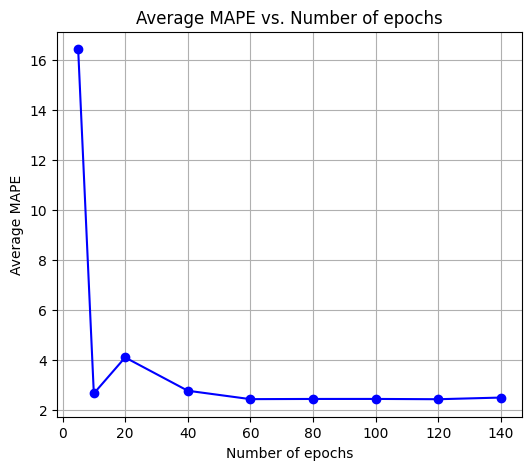

In [34]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(epochs, avg_percentages_diffs_epochs, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('epochs.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()

### R&D ESTIMATION ON A QUARTERLY BASIS (GOOGLE TRENDS DATA)

In [35]:
def extracts_google_trends_quarterly_data(merged_data_google_trends, features_kept):
    """
    Extract quarterly Google Trends data from a merged DataFrame.

    This function extracts quarterly Google Trends data (specified by quartiles) from the merged DataFrame
    'merged_data_google_trends'. It also calculates the sum of features for each quarter and returns separate
    DataFrames for each quarter (quarter1, quarter2, quarter3, quarter4) and the sum across all quarters (quartersum).

    Parameters:
        merged_data_google_trends (pandas.DataFrame): The merged DataFrame containing Google Trends data.
        features_kept (list of str): List of feature column names to be retained.

    Returns:
        tuple of DataFrames: A tuple containing the following DataFrames:
            - quarter1: DataFrame containing data for the first quartile.
            - quarter2: DataFrame containing data for the second quartile.
            - quarter3: DataFrame containing data for the third quartile.
            - quarter4: DataFrame containing data for the fourth quartile.
            - quartersum: DataFrame containing the sum of features across all quarters.
    """
    # Keep only relevant columns and reset the index
    df = merged_data_google_trends.loc[:, features_kept + ["ISO", "year", "quartile"]].reset_index(drop=True)
    
    # Extracting quartile 1
    quarter1 = df[df["quartile"] == 1]
    quarter1 = quarter1.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter1.columns = [col + "_1" if col != "ISO" and col != "year" else col for col in quarter1.columns ]

    # Extracting quartile 2
    quarter2 = df[df["quartile"] == 2]
    quarter2 = quarter2.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter2.columns = [col + "_2" if col != "ISO" and col != "year" else col for col in quarter2.columns ]

    # Extracting quartile 3
    quarter3 = df[df["quartile"] == 3]
    quarter3 = quarter3.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter3.columns = [col + "_3" if col != "ISO" and col != "year" else col for col in quarter3.columns ]

    # Extracting quartile 4
    quarter4 = df[df["quartile"] == 4]
    quarter4 = quarter4.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter4.columns = [col + "_4" if col != "ISO" and col != "year" else col for col in quarter4.columns ]

    # Calculate the sum of features for each quarter and reset the index
    quartersum = df.groupby(["ISO", "year"]).sum()
    quartersum = quartersum.drop(axis=1, columns=["quartile"])
    quartersum = quartersum.reset_index()
    quartersum.columns = [col + "_sum" if col != "ISO" and col != "year" else col for col in quartersum.columns ]

    return quarter1, quarter2, quarter3, quarter4, quartersum


In [36]:
quarter1,quarter2,quarter3,quarter4,quartersum = extracts_google_trends_quarterly_data(merged_data_google_trends,features_kept) 


In [37]:
#Grouping all the quartiles dataframe together , this will be useful to train the model , and evaluate it later
merged_quartiles = pd.merge(quarter1, quarter2, on=["ISO", "year"], how='inner')
merged_quartiles = pd.merge(merged_quartiles, quarter3, on=["ISO", "year"], how='inner')
merged_quartiles = pd.merge(merged_quartiles, quarter4, on=["ISO", "year"], how='inner')
merged_quartiles = pd.merge(merged_quartiles, quartersum, on=["ISO", "year"], how='inner')

merged_quartiles

,Web Apps & Online Tools_1,Business Finance_1,Pharmaceutical Manufacturing_1,Data Management_y_1,Venture Capital_1,Pharmaceuticals & Biotech_1,Genetics_1,Automotive Industry_1,Nanobiotechnology_1,Software Utilities_1,...,Genetics_sum,Automotive Industry_sum,Nanobiotechnology_sum,Software Utilities_sum,Oil & Gas_sum,Renewable Energy_sum,Renewable Energy (Subcategory of Energy & Utilities)_sum,Risk Management_sum,Environmental Science_sum,Artificial Intelligence_sum
0,68.333333,94.666667,94.000000,85.000000,51.666667,96.333333,86.333333,82.333333,97.333333,95.000000,...,305.666667,325.666667,336.000000,332.666667,337.000000,335.000000,334.666667,317.333333,192.333333,314.333333
1,84.000000,81.000000,89.000000,89.333333,26.000000,92.000000,95.000000,79.000000,95.333333,82.333333,...,336.666667,316.333333,346.000000,278.666667,327.000000,326.000000,326.333333,326.333333,321.666667,328.333333
2,53.333333,78.666667,83.666667,74.333333,36.000000,74.000000,0.000000,83.666667,75.333333,90.666667,...,0.000000,318.666667,307.666667,335.000000,335.000000,350.666667,336.000000,327.666667,264.000000,311.333333
3,68.000000,93.333333,77.333333,91.666667,36.000000,94.666667,87.666667,91.666667,94.666667,72.333333,...,307.000000,343.666667,344.000000,266.666667,268.000000,273.666667,334.333333,365.000000,311.333333,334.666667
4,49.333333,84.333333,63.000000,92.666667,15.333333,91.333333,95.333333,94.666667,98.000000,84.333333,...,325.333333,330.666667,345.000000,279.333333,269.666667,268.666667,268.333333,330.333333,244.333333,311.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,68.000000,69.333333,88.333333,64.333333,7.333333,68.666667,42.000000,38.333333,45.333333,32.000000,...,172.000000,158.666667,174.333333,124.666667,162.000000,162.000000,163.000000,97.666667,257.333333,92.000000
140,42.000000,0.000000,0.000000,50.333333,19.333333,29.666667,27.000000,39.666667,27.666667,46.000000,...,100.000000,141.000000,103.666667,174.666667,146.666667,146.666667,146.666667,150.000000,246.000000,127.333333
141,75.666667,54.000000,77.666667,33.000000,6.000000,40.000000,41.666667,47.666667,39.666667,38.666667,...,181.666667,190.000000,174.000000,166.333333,61.000000,61.666667,61.333333,0.000000,249.000000,93.000000
142,40.666667,67.666667,62.333333,0.000000,60.333333,57.666667,29.333333,25.666667,43.666667,90.000000,...,123.666667,96.000000,192.666667,367.333333,324.666667,324.666667,323.666667,369.666667,293.000000,215.000000


In [38]:
#Merging google trends data with R&D expanditures 
google_trends_R_D = pd.merge(first_merged, merged_quartiles, on=['ISO', 'year'], how='inner')
google_trends_R_D = google_trends_R_D.drop(axis =1 ,columns=["ISO","year","v-2"])

#Keep  a copy of this dataframe with quarterly basis data, this will be useful to evaluate our model on a quarterly basis
quartiles_data_frame = google_trends_R_D.copy()

# columns to keep that we will be using to train our model(only columns that represents sums of google trends data),
# also v-1, and v which will be used to evaluate our models 
cols_to_keep = []
for col in google_trends_R_D.columns :
    if col =="v-1" or col=="v" or col.split("_")[-1]=="sum":
        cols_to_keep.append(col)

google_trends_R_D = google_trends_R_D.loc[:,cols_to_keep]
google_trends_R_D

,v-1,v,Web Apps & Online Tools_sum,Business Finance_sum,Pharmaceutical Manufacturing_sum,Data Management_y_sum,Venture Capital_sum,Pharmaceuticals & Biotech_sum,Genetics_sum,Automotive Industry_sum,Nanobiotechnology_sum,Software Utilities_sum,Oil & Gas_sum,Renewable Energy_sum,Renewable Energy (Subcategory of Energy & Utilities)_sum,Risk Management_sum,Environmental Science_sum,Artificial Intelligence_sum
0,1.971243,-0.028245,278.666667,326.666667,327.333333,304.666667,179.000000,340.666667,305.666667,325.666667,336.000000,332.666667,337.000000,335.000000,334.666667,317.333333,192.333333,314.333333
1,1.942999,-0.039421,306.666667,293.000000,308.333333,327.666667,155.333333,297.000000,295.333333,276.666667,272.000000,293.000000,309.666667,307.666667,307.333333,271.333333,176.333333,245.666667
2,1.903578,-0.047800,336.000000,288.666667,277.333333,302.000000,135.000000,278.333333,271.666667,233.666667,221.666667,290.000000,308.666667,312.333333,311.666667,246.666667,154.333333,196.333333
3,1.855778,0.061638,302.000000,249.666667,227.000000,232.666667,105.333333,221.333333,237.333333,233.666667,168.333333,236.000000,272.666667,272.000000,274.666667,180.333333,120.000000,135.666667
4,1.917415,-0.092138,303.333333,247.000000,232.666667,195.666667,86.666667,206.333333,204.333333,199.000000,139.000000,210.000000,226.333333,234.666667,236.333333,154.000000,112.000000,112.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2.853501,0.050823,236.666667,201.666667,225.666667,215.000000,75.333333,106.000000,147.333333,98.333333,149.333333,200.000000,153.333333,153.666667,153.333333,126.666667,157.333333,168.666667
124,2.904324,0.105778,235.000000,231.333333,243.666667,225.666667,78.000000,106.666667,155.000000,102.666667,152.000000,207.000000,154.333333,154.000000,154.000000,132.333333,175.333333,203.666667
125,3.010102,0.160385,235.000000,224.666667,238.000000,216.000000,71.000000,101.666667,148.666667,110.000000,144.000000,199.333333,144.666667,144.666667,145.000000,129.000000,172.000000,205.333333
126,3.170487,0.297284,228.000000,234.000000,232.333333,207.000000,72.000000,102.000000,137.000000,134.666667,140.333333,200.666667,147.666667,147.000000,144.333333,126.666667,165.666667,193.666667


In [39]:
def extract_quarterly_based_dataframes(X_test, merged_quartiles):
    """
    Extract quarterly-based DataFrames from a merged quartiles DataFrame.

    This function takes the testing data X_test and extracts separate DataFrames for each quarter (1, 2, 3, 4) based on the
    provided merged quartiles DataFrame. The DataFrames are filtered to include only columns corresponding to the respective
    quarters.

    Parameters:
        X_test (pandas.DataFrame): The testing data for which quarterly-based DataFrames are extracted.
        merged_quartiles (pandas.DataFrame): The merged quartiles DataFrame containing features for all quarters.

    Returns:
        tuple of DataFrames: A tuple containing the following DataFrames:
            - X_test_quarter1: DataFrame containing data for the first quarter.
            - X_test_quarter2: DataFrame containing data for the second quarter.
            - X_test_quarter3: DataFrame containing data for the third quarter.
            - X_test_quarter4: DataFrame containing data for the fourth quarter.
    """
    # Extracting data for quarter 1
    X_test_quarter1 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep1 = [col for col in X_test_quarter1.columns if col.split("_")[-1] == "1"]
    X_test_quarter1 = X_test_quarter1.loc[:, cols_to_keep1]

    # Extracting data for quarter 2
    X_test_quarter2 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep2 = [col for col in X_test_quarter2.columns if col.split("_")[-1] == "2"]
    X_test_quarter2 = X_test_quarter2.loc[:, cols_to_keep2]

    # Extracting data for quarter 3
    X_test_quarter3 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep3 = [col for col in X_test_quarter3.columns if col.split("_")[-1] == "3"]
    X_test_quarter3 = X_test_quarter3.loc[:, cols_to_keep3]

    # Extracting data for quarter 4
    X_test_quarter4 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep4 = [col for col in X_test_quarter4.columns if col.split("_")[-1] == "4"]
    X_test_quarter4 = X_test_quarter4.loc[:, cols_to_keep4]

    return X_test_quarter1, X_test_quarter2, X_test_quarter3, X_test_quarter4


In [40]:
def train_and_evaluate_quarterly_basis(df, n_folds, merged_quartiles):
    """
    Train and evaluate a model on a quarterly basis using cross-validation.

    This function performs training and evaluation on a given DataFrame `df` with quarterly data using cross-validation.
    It splits the data into `n_folds` folds and calculates the average percentage difference between true and predicted
    R&D expenditure values for each fold.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing R&D expenditure data with quarterly features.
        n_folds (int): The number of folds for cross-validation.
        merged_quartiles (pandas.DataFrame): The DataFrame containing merged quartile-based features.

    Returns:
        None
    """
    fold = 0
    avg_percentages_diffs = []

    # Loop through each fold of cross-validation
    for (train_index, test_index) in cross_validation_indices(df, n_folds):
        
        # Split the data into training and test sets for the current fold
        train_df = df.iloc[train_index]
        train_df = train_df[:]
        test_df = df.iloc[test_index]
        
        # Prepare input data and target data
        X_train = train_df.drop(['v', 'v-1'], axis=1)
        y_train = train_df['v']
        previous_R_D_values = test_df["v-1"]
        X_test = test_df.drop(['v', 'v-1'], axis=1)
        y_test = test_df['v']
        input_shape = X_train.shape[1]
        
        # Train an NLP model
        model,_ = NN_optimized(X_train, y_train, input_shape)
        
        # Extract quarterly-based DataFrames for testing data
        X_test_quarter1, X_test_quarter2, X_test_quarter3, X_test_quarter4 = extract_quarterly_based_dataframes(X_test, merged_quartiles)
        
        # Make predictions for each quarter
        y_pred_quarter1 = model.predict(X_test_quarter1)
        y_pred_quarter2 = model.predict(X_test_quarter2)
        y_pred_quarter3 = model.predict(X_test_quarter3)
        y_pred_quarter4 = model.predict(X_test_quarter4)
        
        # Calculate true and predicted R&D expenditure values for the entire year
        R_D_true_values = previous_R_D_values + y_test
        R_D_predicted_values = previous_R_D_values + y_pred_quarter1.flatten() + y_pred_quarter2.flatten() + y_pred_quarter3.flatten() + y_pred_quarter4.flatten()
        
        # Calculate the average percentage difference for the current fold
        avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
        print(f"the MAPE for the {fold}th fold is : {avg_percentage_diff}%")
        
        # Store the average percentage difference for this fold
        avg_percentages_diffs.append(avg_percentage_diff)
        fold += 1
    
    # Calculate the overall average percentage difference across all folds
    avg_percentage_diff_folds = sum(avg_percentages_diffs) / n_folds 
    print(f"the MAPE for this training is : {avg_percentage_diff_folds}%")
    return avg_percentage_diff_folds


In [41]:
train_and_evaluate_quarterly_basis(google_trends_R_D,5,merged_quartiles)

Epoch 1/80
11/11 [==============================] - 2s 38ms/step - loss: 1565.5095 - val_loss: 55.5293 - lr: 0.0010
Epoch 2/80
11/11 [==============================] - 0s 19ms/step - loss: 46.5859 - val_loss: 92.4524 - lr: 0.0010
Epoch 3/80
11/11 [==============================] - 0s 21ms/step - loss: 32.9717 - val_loss: 4.5125 - lr: 0.0010
Epoch 4/80
11/11 [==============================] - 0s 19ms/step - loss: 15.3660 - val_loss: 25.8363 - lr: 0.0010
Epoch 5/80
11/11 [==============================] - 0s 21ms/step - loss: 49.7866 - val_loss: 45.3903 - lr: 0.0010
Epoch 6/80
11/11 [==============================] - 0s 22ms/step - loss: 48.0489 - val_loss: 18.5726 - lr: 0.0010
Epoch 7/80
11/11 [==============================] - 0s 22ms/step - loss: 14.0966 - val_loss: 1.1436 - lr: 0.0010
Epoch 8/80
11/11 [==============================] - 0s 21ms/step - loss: 3.1314 - val_loss: 2.7300 - lr: 0.0010
Epoch 9/80
11/11 [==============================] - 0s 20ms/step - loss: 2.3608 - val_loss

Epoch 72/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0106 - val_loss: 0.0147 - lr: 5.5166e-06
Epoch 73/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0108 - val_loss: 0.0153 - lr: 4.9916e-06
Epoch 74/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0107 - val_loss: 0.0149 - lr: 4.5166e-06
Epoch 75/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0106 - val_loss: 0.0146 - lr: 4.0868e-06
Epoch 76/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0106 - val_loss: 0.0145 - lr: 3.6979e-06
Epoch 77/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0106 - val_loss: 0.0141 - lr: 3.3460e-06
Epoch 78/80
11/11 [==============================] - 0s 19ms/step - loss: 0.0108 - val_loss: 0.0140 - lr: 3.0276e-06
Epoch 79/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0107 - val_loss: 0.0141 - lr: 2.7394e-06
Epoch 80/80
1/1 [==============================] - 0s 36ms/step


11/11 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 0.0118 - lr: 1.8316e-05
Epoch 61/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0109 - val_loss: 0.0111 - lr: 1.6573e-05
Epoch 62/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 0.0121 - lr: 1.4996e-05
Epoch 63/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0107 - val_loss: 0.0114 - lr: 1.3569e-05
Epoch 64/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0111 - lr: 1.2277e-05
Epoch 65/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 0.0115 - lr: 1.1109e-05
Epoch 66/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.0116 - lr: 1.0052e-05
Epoch 67/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0112 - lr: 9.0953e-06
Epoch 68/80
11/11 [==============================] - 0s 20ms/step - loss: 0.

11/11 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0198 - lr: 6.0810e-05
Epoch 49/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0072 - val_loss: 0.0266 - lr: 5.5023e-05
Epoch 50/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0066 - val_loss: 0.0225 - lr: 4.9787e-05
Epoch 51/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0237 - lr: 4.5049e-05
Epoch 52/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0220 - lr: 4.0762e-05
Epoch 53/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0229 - lr: 3.6883e-05
Epoch 54/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 0.0231 - lr: 3.3373e-05
Epoch 55/80
11/11 [==============================] - 0s 19ms/step - loss: 0.0061 - val_loss: 0.0235 - lr: 3.0197e-05
Epoch 56/80
11/11 [==============================] - 0s 20ms/step - loss: 0.

11/11 [==============================] - 0s 22ms/step - loss: 0.0119 - val_loss: 0.0155 - lr: 2.0190e-04
Epoch 37/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0136 - lr: 1.8268e-04
Epoch 38/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0110 - val_loss: 0.0144 - lr: 1.6530e-04
Epoch 39/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0144 - val_loss: 0.0130 - lr: 1.4957e-04
Epoch 40/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0114 - val_loss: 0.0149 - lr: 1.3534e-04
Epoch 41/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0157 - val_loss: 0.0135 - lr: 1.2246e-04
Epoch 42/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0107 - val_loss: 0.0139 - lr: 1.1080e-04
Epoch 43/80
11/11 [==============================] - 0s 20ms/step - loss: 0.0098 - val_loss: 0.0182 - lr: 1.0026e-04
Epoch 44/80
11/11 [==============================] - 0s 20ms/step - loss: 0.

11/11 [==============================] - 0s 29ms/step - loss: 0.0324 - val_loss: 0.0780 - lr: 6.7032e-04
Epoch 25/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0141 - val_loss: 0.0156 - lr: 6.0653e-04
Epoch 26/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0439 - val_loss: 0.0120 - lr: 5.4881e-04
Epoch 27/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0183 - val_loss: 0.0185 - lr: 4.9659e-04
Epoch 28/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0153 - val_loss: 0.0119 - lr: 4.4933e-04
Epoch 29/80
11/11 [==============================] - 0s 33ms/step - loss: 0.0113 - val_loss: 0.0246 - lr: 4.0657e-04
Epoch 30/80
11/11 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0371 - lr: 3.6788e-04
Epoch 31/80
11/11 [==============================] - 0s 29ms/step - loss: 0.0122 - val_loss: 0.0388 - lr: 3.3287e-04
Epoch 32/80
11/11 [==============================] - 0s 23ms/step - loss: 0.

4.233187064136486